# Imports


In [1]:
# model_config
import torch
import gc
from transformers import Mask2FormerForUniversalSegmentation, Mask2FormerImageProcessor

def clear_model_and_cache():
    """
    Utility function to delete existing model and optimizer objects
    and clear GPU memory to avoid memory leaks.
    """
    if 'model' in globals():
        print("Deleting existing model...")
        del globals()['model']
        del globals()['optimizer']
    gc.collect()
    torch.cuda.empty_cache()

def load_image_processor(pretrained_model_name, do_rescale=True, do_normalize=False, do_resize=True):
    """
    Load the Mask2Former image processor with specified settings.

    Parameters:
    - pretrained_model_name: Hugging Face model name.
    - do_rescale: Whether to rescale image values.
    - do_normalize: Whether to normalize image values.
    - do_resize: Whether to resize the images.

    Returns:
    - image_processor: The configured image processor object.
    """
    image_processor = Mask2FormerImageProcessor.from_pretrained(
        pretrained_model_name,
        do_rescale=do_rescale,
        do_normalize=do_normalize,
        do_resize=do_resize
    )
    return image_processor

def load_mask2former_model(pretrained_model_name, num_labels, ignore_mismatched_sizes=True, freeze_encoder=True):
    """
    Load the Mask2Former model for universal segmentation.

    Parameters:
    - pretrained_model_name: Hugging Face model name.
    - num_labels: Number of segmentation labels (e.g., 2 for binary segmentation).
    - ignore_mismatched_sizes: Whether to allow resizing of model parameters.
    - freeze_encoder: Whether to freeze the encoder backbone.

    Returns:
    - model: The Mask2Former model object.
    """
    model = Mask2FormerForUniversalSegmentation.from_pretrained(
        pretrained_model_name,
        num_labels=num_labels,
        ignore_mismatched_sizes=ignore_mismatched_sizes
    )

    if freeze_encoder:
        # Freeze the encoder backbone
        for name, param in model.named_parameters():
            if "encoder" in name:
                param.requires_grad = False

    return model

def print_trainable_layers(model):
    """
    Display which layers of the model are trainable or frozen.

    Parameters:
    - model: The Mask2Former model.
    """
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name} is trainable")
        else:
            print(f"{name} is frozen")

In [2]:
# preprocess
import os
import numpy as np
from PIL import Image, ImageFilter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch


# Utility functions
def crop_black_borders(image, threshold=30):
    """Crop black borders from an image based on a threshold for black pixels."""
    img_array = np.array(image)
    gray_img = np.mean(img_array, axis=2)  # Convert to grayscale by averaging channels

    # Initialize cropping boundaries
    top, bottom = 0, gray_img.shape[0]
    left, right = 0, gray_img.shape[1]

    # Crop from the top
    while top < bottom and np.mean(gray_img[top, :]) <= threshold:
        top += 1

    # Crop from the bottom
    while bottom > top and np.mean(gray_img[bottom - 1, :]) <= threshold:
        bottom -= 1

    # Crop from the left
    while left < right and np.mean(gray_img[:, left]) <= threshold:
        left += 1

    # Crop from the right
    while right > left and np.mean(gray_img[:, right - 1]) <= threshold:
        right -= 1

    # Crop the image to the calculated bounds
    cropped_image = image.crop((left, top, right, bottom))
    return cropped_image


def gaussian_blur(image, radius=2):
    """Apply Gaussian blur to an image to avoid capturing noise as tissue."""
    return image.filter(ImageFilter.GaussianBlur(radius=radius))


def preprocess_image(image_path, target_size=(128, 128)):
    """Preprocess an image: crop black borders, enhance contrast, and resize."""
    image = Image.open(image_path).convert("RGB")
    # cropped_image = crop_black_borders(image) # cropping causes probllems

    # Blur to remove noise
    blurred_image = gaussian_blur(image, 2)  # Increase radius if desired for more blur

    # Resize to the target size
    resized_image = blurred_image.resize(target_size, Image.BICUBIC)

    return resized_image


def preprocess_mask(mask_path, target_size=(128, 128)):
    """Convert mask to binary, ensure tissue is white and background is black, and resize."""
    mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale
    mask_array = np.array(mask)

    # Apply binary threshold and ensure tissue is white, background is black
    binary_mask = np.where(mask_array > 0, 1, 0).astype(np.uint8)  # Normalize mask to [0, 1]
    binary_mask = Image.fromarray(binary_mask * 255)  # Convert back to PIL Image

    # Resize to the target size using nearest-neighbor interpolation
    resized_mask = binary_mask.resize(target_size, Image.NEAREST)

    return resized_mask


# Dataset class
class TissueDataset(Dataset):
    def __init__(self, image_files, mask_files, image_processor=None, mask_transform=None, augmentations=None):
        """
        Initialize the TissueDataset.

        Parameters:
        - image_files: List of image file paths.
        - mask_files: List of mask file paths.
        - image_processor: Preprocessing function for images (expects PIL input).
        - mask_transform: Preprocessing function for masks.
        """
        self.image_files = image_files
        self.mask_files = mask_files
        self.image_processor = image_processor
        self.mask_transform = mask_transform
        # self.augmentations = augmentations

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and mask as PIL images
        image = Image.open(self.image_files[idx]).convert("RGB")  # Convert to PIL RGB
        mask = Image.open(self.mask_files[idx]).convert("L")  # Convert to PIL Grayscale

        # if self.augmentations:
        #   # augmented = self.augmentations(transforms.ToTensor()(image), transforms.ToTensor()(mask))
        #   image = self.augmentations(transforms.ToTensor()(image))
        #   mask = self.augmentations(transforms.ToTensor()(mask))
        #   # image, mask = augmented

        # Process images
        image = preprocess_image(self.image_files[idx])
        mask = preprocess_mask(self.mask_files[idx])

        # Process image using the image processor
        if self.image_processor:
            image = self.image_processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)

        # Process the mask using mask_transform (if provided)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask


# Data preparation functions
def get_file_paths(image_folder, mask_folder):
    """Retrieve sorted lists of image and mask file paths."""
    image_files = [os.path.join(image_folder, f) for f in sorted(os.listdir(image_folder))]
    mask_files = [os.path.join(mask_folder, f) for f in sorted(os.listdir(mask_folder))]
    assert len(image_files) == len(mask_files), "Mismatch between image and mask files."
    return image_files, mask_files


# Define transforms for images and masks
image_transform = transforms.Compose([

    transforms.ToTensor(),  # Convert to tensor
])

mask_transform = transforms.Compose([

    transforms.ToTensor(),  # Convert to tensor
])

# Define augmentations
# augmentations = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.5),
#     transforms.RandomRotation(degrees=30),
# ])


def create_dataloaders(image_folder, mask_folder, batch_size=16, image_processor=None, mask_transform=mask_transform,
                       image_transform=image_transform, divide=1):
    """
    Create train and validation DataLoaders.

    Parameters:
    - image_folder: Path to the image folder.
    - mask_folder: Path to the mask folder.
    - batch_size: Batch size for DataLoaders.
    - image_processor: Optional image processor for preprocessing.
    - mask_transform: Optional transform for masks.
    - divide: Divide the dataset by this number. Default is 1.

    Returns:
    - train_loader: DataLoader for the training set.
    - val_loader: DataLoader for the validation set.
    """

    # Get image and mask file paths
    image_files, mask_files = get_file_paths(image_folder, mask_folder)

    # Create dataset
    dataset = TissueDataset(
        image_files=image_files,
        mask_files=mask_files,
        image_processor=image_processor,  # Pass the image processor here
        mask_transform=mask_transform  # Pass the mask transform here
        # ,augmentations=augmentations
    )

    # Cut dataset for testing (optional for quick parameter testing)
    dataset = torch.utils.data.Subset(dataset, range(0, len(dataset) // divide))

    # Split dataset into train and validation sets
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, dataset, image_files, mask_files

In [18]:
# train
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
# from loss import *


def calculate_metrics(output, target):
    """
    Compute IoU, Dice, and pixel accuracy for given outputs and ground truth masks.

    Args:
        output: Predicted segmentation logits (after resizing and applying activation).
        target: Ground truth segmentation masks.

    Returns:
        avg_iou: Average Intersection over Union (IoU) for the batch.
        avg_dice: Average Dice coefficient for the batch.
        pixel_accuracy: Pixel accuracy across all samples in the batch.
    """
    predicted_masks = (output > 0.5).cpu().numpy().astype(np.uint8)
    ground_truth_masks_np = target.cpu().numpy().astype(np.uint8)

    # Compute metrics
    num_samples = 0
    total_iou = 0
    total_dice = 0
    for pred, gt in zip(predicted_masks, ground_truth_masks_np):
        total_iou += calculate_iou_infer(pred, gt)
        total_dice += calculate_dice_infer(pred, gt)
        num_samples += 1

    # Calculate pixel accuracy
    matching_pixels = torch.tensor(predicted_masks == ground_truth_masks_np).sum()  # Count matching pixels per batch
    total_pixels = torch.tensor(predicted_masks).numel()  # Total number of pixels per batch
    pixel_accuracy = float(matching_pixels) / total_pixels

    # Calculate average IoU and Dice metrics
    avg_iou = total_iou / num_samples if num_samples > 0 else 0
    avg_dice = total_dice / num_samples if num_samples > 0 else 0

    return avg_iou, avg_dice, pixel_accuracy


def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, device="cuda"):
    """
    Train the segmentation model and evaluate metrics after each epoch.

    Args:
        model: The segmentation model to train.
        train_loader: DataLoader providing training images and masks.
        val_loader: DataLoader providing validation images and masks.
        criterion: Loss function for training and validation.
        optimizer: Optimizer for updating model weights.
        num_epochs: Number of training epochs.
        device: Computation device (CPU or CUDA).

    Returns:
        train_metrics: Dictionary containing training loss, IoU, Dice, and pixel accuracy per epoch.
        val_metrics: Dictionary containing validation loss, IoU, Dice, and pixel accuracy per epoch.
    """
    train_metrics = {'loss': [], 'iou': [], 'dice': [], 'pixel_acc': []}
    val_metrics = {'loss': [], 'iou': [], 'dice': [], 'pixel_acc': []}
    model.to(device)
    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()
        running_loss = 0.0
        running_iou = 0.0
        running_dice = 0.0
        running_pixel_acc = 0.0

        for pixel_values, masks in tqdm(train_loader, desc=f"Epoch [{epoch + 1}/{num_epochs}] Training"):
            # Move inputs and masks to the correct device
            pixel_values = pixel_values.to(device, dtype=next(model.parameters()).dtype)  # Match model dtype
            masks = masks.to(device, dtype=torch.float32)  # Ensure masks are on the correct device and float32

            # Forward pass
            outputs = model(pixel_values=pixel_values)
            tissue_logits = outputs.masks_queries_logits[:, 1]  # Binary segmentation logits

            # Resize logits to match masks
            tissue_logits_resized = torch.sigmoid(F.interpolate(
                tissue_logits.unsqueeze(1),  # Add channel dimension
                size=masks.shape[-2:],  # Match mask size
                mode="bilinear",
                align_corners=False
            ))  # Keep channel dimension for metrics

            # Compute loss
            loss = criterion(tissue_logits_resized, masks)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate loss and metrics
            running_loss += loss.item()
            iou, dice, pixel_accuracy = calculate_metrics(tissue_logits_resized, masks)
            running_iou += iou
            running_dice += dice
            running_pixel_acc += pixel_accuracy

        # Average training metrics
        avg_train_loss = running_loss / len(train_loader)
        avg_train_iou = running_iou / len(train_loader)
        avg_train_dice = running_dice / len(train_loader)
        avg_train_pixel_accuracy = running_pixel_acc / len(train_loader)
        train_metrics['loss'].append(avg_train_loss)
        train_metrics['iou'].append(avg_train_iou)
        train_metrics['dice'].append(avg_train_dice)
        train_metrics['pixel_acc'].append(avg_train_pixel_accuracy)
        print(
            f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training IoU: {avg_train_iou:.4f}, Training Dice: {avg_train_dice:.4f}, Training Pixel Acc: {avg_train_pixel_accuracy:.4f}")

        # Perform validation
        avg_val_loss, avg_iou, avg_dice, avg_pixel_acc = validate_with_augmentation(model, val_loader, criterion, device)
        val_metrics['loss'].append(avg_val_loss)
        val_metrics['iou'].append(avg_iou)
        val_metrics['dice'].append(avg_dice)
        val_metrics['pixel_acc'].append(avg_pixel_acc)

        print(
            f"Epoch [{epoch + 1}/{num_epochs}] Validation - Loss: {avg_val_loss:.4f}, IoU: {avg_iou:.4f}, Dice: {avg_dice:.4f}, Pixel acc: {avg_pixel_acc:.4f}\n")

        # Stop criteria
        if avg_train_iou < 0.3:
            print("Stopping criteria: not enough potential!")
            return train_metrics, val_metrics

    return train_metrics, val_metrics


def validate(model, val_loader, criterion, device):
    """
    Validate the segmentation model and compute evaluation metrics.

    Args:
        model: The trained segmentation model.
        val_loader: DataLoader providing validation images and ground truth masks.
        criterion: Loss function for evaluation.
        device: Computation device (CPU or CUDA).

    Returns:
        avg_val_loss: Average validation loss across the validation set.
        avg_iou: Average Intersection over Union (IoU) across the validation set.
        avg_dice: Average Dice coefficient across the validation set.
        avg_pixel_acc: Average pixel accuracy across the validation set.
    """
    model.eval()
    val_loss = 0.0
    total_iou = 0.0
    total_dice = 0.0
    total_pixel_acc = 0.0
    num_samples = 0

    with torch.no_grad():
        for images, ground_truth_masks in tqdm(val_loader, desc="Validation"):
            # Move inputs and masks to the correct device
            images = images.to(device)
            ground_truth_masks = ground_truth_masks.to(device, dtype=torch.float32)

            # Forward pass
            outputs = model(pixel_values=images)
            tissue_logits = outputs.masks_queries_logits[:, 1]  # Binary segmentation logits

            # Resize logits to match mask size
            tissue_logits_resized = torch.sigmoid(F.interpolate(
                tissue_logits.unsqueeze(1),  # Add channel dimension
                size=ground_truth_masks.shape[-2:],  # Match mask size
                mode="bilinear",
                align_corners=False
            ))  # Keep channel dimension for metrics

            # Compute loss
            loss = criterion(tissue_logits_resized, ground_truth_masks)
            val_loss += loss.item()

            # Calculate metrics
            predicted_masks = (tissue_logits_resized > 0.5).cpu().numpy().astype(np.uint8)
            ground_truth_masks_np = ground_truth_masks.cpu().numpy().astype(np.uint8)

            for pred, gt in zip(predicted_masks, ground_truth_masks_np):
                total_iou += calculate_iou_infer(pred, gt)
                total_dice += calculate_dice_infer(pred, gt)
                num_samples += 1

            matching_pixels = (predicted_masks == ground_truth_masks_np).sum()  # Count matching pixels per batch
            total_pixels = torch.tensor(predicted_masks).numel()
            total_pixel_acc += float(matching_pixels) / total_pixels

    # Calculate average metrics
    avg_val_loss = val_loss / len(val_loader)
    avg_val_pixel_acc = total_pixel_acc / len(val_loader)
    avg_iou = total_iou / num_samples if num_samples > 0 else 0
    avg_dice = total_dice / num_samples if num_samples > 0 else 0

    return avg_val_loss, avg_iou, avg_dice, avg_val_pixel_acc

In [4]:
# from torchvision.transforms.v2.functional import hflip, vflip

# def validate_with_augmentation(model, val_loader, criterion, device, threshold=0.3):
#     """
#     Validate the segmentation model using augmented versions of the input (rotations and flips).

#     Args:
#         model: The trained segmentation model.
#         val_loader: DataLoader providing validation images and ground truth masks.
#         criterion: Loss function for evaluation.
#         device: Computation device (CPU or CUDA).
#         threshold: Threshold to convert logits to binary predictions (default=0.5).

#     Returns:
#         avg_val_loss: Average validation loss across the augmented validation set.
#         avg_iou: Average Intersection over Union (IoU) across the augmented validation set.
#         avg_dice: Average Dice coefficient across the augmented validation set.
#         avg_pixel_acc: Average pixel accuracy across the augmented validation set.
#     """
#     model.eval()
#     val_loss = 0.0
#     total_iou = 0.0
#     total_dice = 0.0
#     total_pixel_acc = 0.0
#     num_samples = 0

#     with torch.no_grad():
#         for images, ground_truth_masks in tqdm(val_loader, desc="Validation with Augmentation"):
#             # Move inputs and masks to the correct device
#             images = images.to(device)
#             ground_truth_masks = ground_truth_masks.to(device, dtype=torch.float32)

#             # Store predictions for the original and augmented versions
#             all_predictions = []

#             # Generate outputs for the original image
#             outputs = model(pixel_values=images)
#             tissue_logits = outputs.masks_queries_logits[:, 1]  # Binary segmentation logits
#             tissue_logits_resized = torch.sigmoid(F.interpolate(
#                 tissue_logits.unsqueeze(1),  # Add channel dimension
#                 size=ground_truth_masks.shape[-2:],  # Match mask size
#                 mode="bilinear",
#                 align_corners=False
#             ))
#             all_predictions.append(tissue_logits_resized)

#             # Generate outputs for augmented versions
#             augmented_images = [hflip(images), vflip(images), hflip(vflip(images))]
#             for aug_image in augmented_images:
#                 aug_outputs = model(pixel_values=aug_image)
#                 aug_logits = aug_outputs.masks_queries_logits[:, 1]
#                 aug_logits_resized = torch.sigmoid(F.interpolate(
#                     aug_logits.unsqueeze(1),
#                     size=ground_truth_masks.shape[-2:],
#                     mode="bilinear",
#                     align_corners=False
#                 ))
#                 # Flip the augmented prediction back to match the original orientation
#                 if aug_image is hflip(images):
#                     aug_logits_resized = hflip(aug_logits_resized)
#                 elif aug_image is vflip(images):
#                     aug_logits_resized = vflip(aug_logits_resized)
#                 elif aug_image is hflip(vflip(images)):
#                     aug_logits_resized = hflip(vflip(aug_logits_resized))

#                 all_predictions.append(aug_logits_resized)

#             # Compute the average of all predictions
#             avg_prediction = torch.stack(all_predictions).mean(dim=0)

#             # Compute loss
#             loss = criterion(avg_prediction, ground_truth_masks)
#             val_loss += loss.item()

#             # Calculate metrics
#             predicted_masks = (avg_prediction > threshold).cpu().numpy().astype(np.uint8)
#             ground_truth_masks_np = ground_truth_masks.cpu().numpy().astype(np.uint8)

#             for pred, gt in zip(predicted_masks, ground_truth_masks_np):
#                 total_iou += calculate_iou_infer(pred, gt)
#                 total_dice += calculate_dice_infer(pred, gt)
#                 num_samples += 1

#             matching_pixels = (predicted_masks == ground_truth_masks_np).sum()  # Count matching pixels per batch
#             total_pixels = torch.tensor(predicted_masks).numel()
#             total_pixel_acc += float(matching_pixels) / total_pixels

#     # Calculate average metrics
#     avg_val_loss = val_loss / len(val_loader)
#     avg_val_pixel_acc = total_pixel_acc / len(val_loader)
#     avg_iou = total_iou / num_samples if num_samples > 0 else 0
#     avg_dice = total_dice / num_samples if num_samples > 0 else 0

#     return avg_val_loss, avg_iou, avg_dice, avg_val_pixel_acc


In [17]:
from torchvision.transforms.v2.functional import hflip, vflip

def validate_with_augmentation(
    model, val_loader, criterion, device, threshold=0.5
):
    """
    Validate the segmentation model using augmented versions of the input (rotations and flips).

    Args:
        model: The trained segmentation model.
        val_loader: DataLoader providing validation images and ground truth masks.
        criterion: Loss function for evaluation.
        device: Computation device (CPU or CUDA).
        threshold: Threshold to convert logits to binary predictions (default=0.5).

    Returns:
        avg_val_loss: Average validation loss across the augmented validation set.
        avg_iou: Average Intersection over Union (IoU) across the augmented validation set.
        avg_dice: Average Dice coefficient across the augmented validation set.
        avg_pixel_acc: Average pixel accuracy across the augmented validation set.
    """
    model.eval()
    val_loss = 0.0
    total_iou = 0.0
    total_dice = 0.0
    total_pixel_acc = 0.0
    num_samples = 0

    with torch.no_grad():
        for images, ground_truth_masks in tqdm(val_loader, desc="Validation with Augmentation"):
            # Move inputs and masks to the correct device
            images = images.to(device)
            ground_truth_masks = ground_truth_masks.to(device, dtype=torch.float32)

            # Store predictions for the original and augmented versions
            all_predictions = []

            # Generate outputs for the original image
            outputs = model(pixel_values=images)
            tissue_logits = outputs.masks_queries_logits[:, 1]  # Binary segmentation logits
            tissue_logits_resized = torch.sigmoid(F.interpolate(
                tissue_logits.unsqueeze(1),  # Add channel dimension
                size=ground_truth_masks.shape[-2:],  # Match mask size
                mode="bilinear",
                align_corners=False
            ))
            all_predictions.append(tissue_logits_resized)

            # Generate outputs for augmented versions
            augmented_images = [hflip(images), vflip(images), hflip(vflip(images))]
            for idx, aug_image in enumerate(augmented_images):
                aug_outputs = model(pixel_values=aug_image)
                aug_logits = aug_outputs.masks_queries_logits[:, 1]
                aug_logits_resized = torch.sigmoid(F.interpolate(
                    aug_logits.unsqueeze(1),
                    size=ground_truth_masks.shape[-2:],
                    mode="bilinear",
                    align_corners=False
                ))
                # Flip the augmented prediction back to match the original orientation
                if idx == 0:  # hflip
                    aug_logits_resized = hflip(aug_logits_resized)
                elif idx == 1:  # vflip
                    aug_logits_resized = vflip(aug_logits_resized)
                elif idx == 2:  # hflip + vflip
                    aug_logits_resized = hflip(vflip(aug_logits_resized))

                all_predictions.append(aug_logits_resized)

            # Compute the average of all predictions
            avg_prediction = torch.stack(all_predictions).mean(dim=0)

            # Compute loss
            loss = criterion(avg_prediction, ground_truth_masks)
            val_loss += loss.item()

            # Calculate metrics
            predicted_masks = (avg_prediction > threshold).cpu().numpy().astype(np.uint8)
            ground_truth_masks_np = ground_truth_masks.cpu().numpy().astype(np.uint8)

            for pred, gt in zip(predicted_masks, ground_truth_masks_np):
                total_iou += calculate_iou_infer(pred, gt)
                total_dice += calculate_dice_infer(pred, gt)
                num_samples += 1

            matching_pixels = (predicted_masks == ground_truth_masks_np).sum()  # Count matching pixels per batch
            total_pixels = np.prod(predicted_masks.shape)
            total_pixel_acc += float(matching_pixels) / total_pixels

    # Calculate average metrics
    avg_val_loss = val_loss / len(val_loader)
    avg_val_pixel_acc = total_pixel_acc / len(val_loader)
    avg_iou = total_iou / num_samples if num_samples > 0 else 0
    avg_dice = total_dice / num_samples if num_samples > 0 else 0

    return avg_val_loss, avg_iou, avg_dice, avg_val_pixel_acc


In [6]:
# utils
import os
from transformers import Mask2FormerForUniversalSegmentation, Mask2FormerImageProcessor

def save_model_and_processor(model, image_processor, save_dir):
    """
    Save the trained model and image processor to a specified directory.

    Args:
        model: The trained Mask2Former model.
        image_processor: The corresponding image processor used for preprocessing.
        save_dir: Path to the directory where the model and processor will be saved.
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    model.save_pretrained(save_dir)
    image_processor.save_pretrained(save_dir)
    print(f"Model and image processor saved to {save_dir}")

def load_model_and_processor(save_dir):
    """
    Load a trained Mask2Former model and its corresponding image processor from a directory.

    Args:
        save_dir: Path to the directory where the model and processor are stored.

    Returns:
        model: The loaded Mask2Former model.
        image_processor: The loaded image processor.
    """
    if not os.path.exists(save_dir):
        raise FileNotFoundError(f"Directory {save_dir} does not exist.")

    model = Mask2FormerForUniversalSegmentation.from_pretrained(save_dir)
    image_processor = Mask2FormerImageProcessor.from_pretrained(save_dir)
    print(f"Model and image processor loaded from {save_dir}")
    return model, image_processor

In [7]:
# inference
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F



def calculate_iou_infer(pred, target):
    """
    Calculate Intersection over Union (IoU) between two binary masks.
    Treat cases with zero union as perfect matches.

    Args:
        pred (numpy.ndarray): Predicted binary mask.
        target (numpy.ndarray): Ground truth binary mask.

    Returns:
        float: IoU score.
    """
    pred = (pred > 0.5).astype(np.uint8)
    target = (target > 0.5).astype(np.uint8)
    intersection = np.logical_and(pred, target).sum()
    union = np.logical_or(pred, target).sum()

    if union == 0:  # If union is zero, treat as a perfect match
        return 1.0

    return intersection / (union + 1e-6)  # Calculate IoU

def calculate_dice_infer(pred, target):
    """
    Calculate Dice coefficient between two binary masks.
    Treat cases with zero denominator as perfect matches.

    Args:
        pred (numpy.ndarray): Predicted binary mask.
        target (numpy.ndarray): Ground truth binary mask.

    Returns:
        float: Dice coefficient score.
    """
    pred = (pred > 0.5).astype(np.uint8)
    target = (target > 0.5).astype(np.uint8)
    intersection = np.logical_and(pred, target).sum()
    denominator = pred.sum() + target.sum()

    if denominator == 0:  # If denominator is zero, treat as a perfect match
        return 1.0

    return (2 * intersection) / (denominator + 1e-6)  # Calculate Dice

def infer_and_display(model, image_processor, dataloader, device, num_samples=5, target_size=(128, 128)):
    """
    Perform inference and display the original image, ground truth mask, and predicted mask side by side.
    Additionally, calculate IoU, Dice, and Pixel Accuracy.

    Args:
        model: The trained segmentation model.
        image_processor: Preprocessing module for the input images.
        dataloader: DataLoader providing images and ground truth masks.
        device: Computation device (CPU or CUDA).
        num_samples: Number of samples to visualize.
        target_size: Target size for resizing masks during visualization.
    """
    model.eval()
    samples_displayed = 0
    total_iou = 0.0
    total_dice = 0.0
    total_pixel_acc = 0.0
    num_evaluated = 0

    with torch.no_grad():
        for images, ground_truth_masks in tqdm(dataloader, desc="Inferencing"):
            # Move ground truth masks to device and convert to float
            ground_truth_masks = ground_truth_masks.to(device, dtype=torch.float32)

            # Convert tensors to PIL images for the image processor
            pil_images = [transforms.ToPILImage()(img) for img in images]
            inputs = image_processor(images=pil_images, return_tensors="pt")
            pixel_values = inputs["pixel_values"].to(device)

            # Forward pass
            outputs = model(pixel_values=pixel_values)
            tissue_logits = outputs.masks_queries_logits[:, 1]  # Binary segmentation logits

            # Resize logits to match mask size
            tissue_logits_resized = torch.sigmoid(F.interpolate(
                tissue_logits.unsqueeze(1),
                size=ground_truth_masks.shape[-2:],  # Match ground truth mask size
                mode="bilinear",
                align_corners=False
            ).squeeze(1))  # Remove channel dimension

            # Convert predicted logits to binary masks
            predicted_masks = (tissue_logits_resized > 0.5).cpu().numpy().astype(np.uint8)

            # Display the first few samples
            for i in range(len(images)):
                if samples_displayed >= num_samples:
                    # Print the average metrics
                    avg_iou = total_iou / num_evaluated
                    avg_dice = total_dice / num_evaluated
                    avg_pixel_acc = total_pixel_acc / num_evaluated
                    print(f"\nMean IoU: {avg_iou:.4f}")
                    print(f"Mean Dice: {avg_dice:.4f}")
                    print(f"Mean Pixel Accuracy: {avg_pixel_acc:.4f}")
                    return

                # Convert images, ground truths, and predictions to displayable formats
                original_image = pil_images[i]
                ground_truth_mask = ground_truth_masks[i].cpu().numpy().squeeze()  # Remove extra dimensions
                predicted_mask = predicted_masks[i]

                # Ensure ground truth mask is binary (0 or 1) and scaled to 255
                ground_truth_mask = (ground_truth_mask > 0.5).astype(np.uint8) * 255

                # Calculate IoU, Dice, and Pixel Accuracy for the current sample
                iou = calculate_iou_infer(predicted_mask, ground_truth_mask // 255)  # Divide by 255 for binary comparison
                dice = calculate_dice_infer(predicted_mask, ground_truth_mask // 255)  # Divide by 255 for binary comparison
                pixel_acc = np.mean(predicted_mask == (ground_truth_mask // 255))
                total_iou += iou
                total_dice += dice
                total_pixel_acc += pixel_acc
                num_evaluated += 1

                # Resize ground truth and predicted masks for visualization
                ground_truth_mask_resized = np.array(Image.fromarray(ground_truth_mask).resize(target_size, Image.NEAREST))
                predicted_mask_resized = np.array(Image.fromarray((predicted_mask * 255).astype(np.uint8)).resize(target_size, Image.NEAREST))

                # Display side by side
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                axs[0].imshow(original_image)
                axs[0].set_title(f"Original Image {samples_displayed + 1}")
                axs[0].axis("off")

                axs[1].imshow(ground_truth_mask_resized, cmap="gray", vmin=0, vmax=255)
                axs[1].set_title(f"Ground Truth Mask {samples_displayed + 1}")
                axs[1].axis("off")

                axs[2].imshow(predicted_mask_resized, cmap="gray", vmin=0, vmax=255)
                axs[2].set_title(f"Predicted Mask {samples_displayed + 1}")
                axs[2].axis("off")

                plt.show()
                samples_displayed += 1

    # Print the final average metrics
    avg_iou = total_iou / num_evaluated if num_evaluated > 0 else 0
    avg_dice = total_dice / num_evaluated if num_evaluated > 0 else 0
    avg_pixel_acc = total_pixel_acc / num_evaluated if num_evaluated > 0 else 0
    print(f"\nMean IoU: {avg_iou:.4f}")
    print(f"Mean Dice: {avg_dice:.4f}")
    print(f"Mean Pixel Accuracy: {avg_pixel_acc:.4f}")

In [8]:
# loss
import torch
import torch.nn as nn
import numpy as np
from torch.nn.functional import conv2d


def should_return_low_loss(inputs, targets, threshold_zero_loss):
    """Helper function for loss"""

    return (inputs.sum(dim=(1, 2, 3)) <= threshold_zero_loss) & (targets.sum(dim=(1, 2, 3)) <= threshold_zero_loss)


def compute_low_loss(inputs, targets, threshold_zero_loss):
    """ Helper function for loss"""
    return 1 / 2 ** ((2.75 * threshold_zero_loss - inputs.sum(dim=(1, 2, 3)) - targets.sum(dim=(1, 2, 3))))


class DiceLoss(nn.Module):
    """
    Dice Loss for binary segmentation tasks. Measures the overlap between
    predicted and ground truth masks, emphasizing small structures.
    """

    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Flatten tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Calculate Dice score
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice


class BoundaryDiceLoss(nn.Module):
    """
    Dice loss paired with boundary loss
    """

    def __init__(self, smooth=1, boundary_weight=0.5, threshold_zero_loss=10):
        """
        Balanced means that the weights is calculated using the
        proportion of pixels of each type in the predicted image
        """
        super(BoundaryDiceLoss, self).__init__()
        self.tissueDice = DiceLoss(smooth)
        self.boundaryDice = DiceLoss(smooth)
        self.threshold_zero_loss = threshold_zero_loss
        self.boundary_weight = boundary_weight

    def boundary_loss(self, predictions, targets):
        kernel = torch.ones((1, 1, 3, 3), device=predictions.device)
        pred_boundaries = conv2d(predictions, kernel, padding=1).clamp(0, 1) - predictions
        target_boundaries = conv2d(targets, kernel, padding=1).clamp(0, 1) - targets
        return pred_boundaries, target_boundaries

    def forward(self, inputs, targets):
        mask_of_low_loss = should_return_low_loss(inputs, targets, self.threshold_zero_loss)

        inputs_low_loss = inputs[mask_of_low_loss]
        targets_low_loss = targets[mask_of_low_loss]

        if inputs_low_loss.numel() > 0:
            low_losses = compute_low_loss(inputs_low_loss, targets_low_loss, self.threshold_zero_loss)
        else:
            low_losses = torch.tensor(0.0, device=inputs.device)

        inputs_normal_loss = inputs[~mask_of_low_loss]
        targets_normal_loss = targets[~mask_of_low_loss]

        if inputs_normal_loss.numel() > 0:
            normal_losses = self.tissueDice(inputs_normal_loss,
                                            targets_normal_loss) + self.boundary_weight * self.boundaryDice(
                *self.boundary_loss(inputs_normal_loss, targets_normal_loss))
        else:
            normal_losses = torch.tensor(0.0, device=inputs.device)

        return (
            ~mask_of_low_loss).float().mean() * normal_losses.mean() + mask_of_low_loss.float().mean() * low_losses.mean()


class ScaledDiceLoss(nn.Module):
    """
    Scaled version of the dice loss
    """

    def __init__(self, smooth=1, threshold_zero_loss=10):
        super(ScaledDiceLoss, self).__init__()
        self.tissueDice = DiceLoss(smooth)
        self.threshold_zero_loss = threshold_zero_loss

    def forward(self, inputs, targets):
        mask_of_low_loss = should_return_low_loss(inputs, targets, self.threshold_zero_loss)

        inputs_low_loss = inputs[mask_of_low_loss]
        targets_low_loss = targets[mask_of_low_loss]

        if inputs_low_loss.numel() > 0:
            low_losses = compute_low_loss(inputs_low_loss, targets_low_loss, self.threshold_zero_loss)
        else:
            low_losses = torch.tensor(0.0, device=inputs.device)

        inputs_normal_loss = inputs[~mask_of_low_loss]
        targets_normal_loss = targets[~mask_of_low_loss]

        if inputs_normal_loss.numel() > 0:
            scaling_factor = torch.log(
                (inputs_normal_loss.sum() + targets_normal_loss.sum()) / inputs_normal_loss.size(0))
            normal_losses = scaling_factor * self.tissueDice(inputs_normal_loss, targets_normal_loss)
        else:
            normal_losses = torch.tensor(0.0, device=inputs.device)

        return (
            ~mask_of_low_loss).float().mean() * normal_losses.mean() + mask_of_low_loss.float().mean() * low_losses.mean()


def calculate_iou_infer(pred, target):
    """
    Calculate Intersection over Union (IoU) between two binary masks.
    Treat cases with zero union as perfect matches.

    Args:
        pred (numpy.ndarray): Predicted binary mask.
        target (numpy.ndarray): Ground truth binary mask.

    Returns:
        float: IoU score.
    """
    pred = (pred > 0.5).astype(np.uint8)
    target = (target > 0.5).astype(np.uint8)
    intersection = np.logical_and(pred, target).sum()
    union = np.logical_or(pred, target).sum()

    if union == 0:  # If union is zero, treat as a perfect match
        return 1.0

    return intersection / (union + 1e-6)  # Calculate IoU


def calculate_dice_infer(pred, target):
    """
    Calculate Dice coefficient between two binary masks.
    Treat cases with zero denominator as perfect matches.

    Args:
        pred (numpy.ndarray): Predicted binary mask.
        target (numpy.ndarray): Ground truth binary mask.

    Returns:
        float: Dice coefficient score.
    """
    pred = (pred > 0.5).astype(np.uint8)
    target = (target > 0.5).astype(np.uint8)
    intersection = np.logical_and(pred, target).sum()
    denominator = pred.sum() + target.sum()

    if denominator == 0:  # If denominator is zero, treat as a perfect match
        return 1.0

    return (2 * intersection) / (denominator + 1e-6)  # Calculate Dice


class CombinedDiceBCELoss(nn.Module):
    """
    Combined Dice and Binary Cross-Entropy (BCE) Loss.

    Args:
        dice_weight (float): Weight for Dice Loss.
        bce_weight (float): Weight for BCE Loss.
        smooth (float): Smoothing factor to avoid division by zero.
    """

    def __init__(self, dice_weight=0.5, bce_weight=0.5, smooth=1e-6):
        super(CombinedDiceBCELoss, self).__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.smooth = smooth
        self.dice = DiceLoss(smooth)
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, logits, targets):
        ## Calculate Dice loss
        dice_loss = self.dice(logits, targets)

        ## Calculate BCE loss
        bce_loss = self.bce(logits, targets)

        # Combine Dice and BCE losses
        return self.dice_weight * dice_loss + self.bce_weight * bce_loss


class DoubleDiceLoss(nn.Module):
    """
    Combination of the dice loss of the background and tissue.
    """

    def __init__(self, smooth=1, weight_tissue='balanced'):
        """
        Balanced means that the weights is calculated using the
        proportion of pixels of each type in the predicted image
        """
        super(DoubleDiceLoss, self).__init__()
        self.tissueDice = DiceLoss(smooth)
        self.backgroundDice = DiceLoss(smooth)
        self.weight_tissue = weight_tissue

    def forward(self, inputs, targets):
        if self.weight_tissue == 'balanced':
            num_ones = targets.sum()
            total_pixels = targets.numel()
            weight_tissue = num_ones.float() / total_pixels
        else:
            weight_tissue = self.weight_tissue

        inverted_inputs = (-inputs + inputs.max())
        inverted_masks = (-targets + inputs.max())

        return weight_tissue * self.tissueDice(inputs, targets) + (1 - weight_tissue) * self.tissueDice(inverted_inputs,
                                                                                                        inverted_masks)

In [9]:
# data_visualization
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np

def verify_data_alignment(dataset, image_files, num_samples=5):
    """
    Verify data processing by displaying original images, preprocessed images, and processed masks.

    Args:
        dataset: Dataset object that provides preprocessed images and masks.
        image_files: List of full paths to the original image files.
        num_samples: Number of samples to visualize.
    """
    for i in range(num_samples):
        # Retrieve the preprocessed image and mask from the dataset
        preprocessed_image, processed_mask = dataset[i]

        # Convert tensors to PIL images for visualization
        preprocessed_image_pil = transforms.ToPILImage()(preprocessed_image)
        processed_mask_pil = transforms.ToPILImage()(processed_mask)

        # Load the original image (image_files already contains the full path)
        original_image = Image.open(image_files[i]).convert("RGB")

        # Display the original image, preprocessed image, and processed mask side by side
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        axs[0].imshow(original_image)
        axs[0].set_title(f"Original Image {i + 1}")
        axs[0].axis("off")

        axs[1].imshow(preprocessed_image_pil)
        axs[1].set_title(f"Preprocessed Image {i + 1}")
        axs[1].axis("off")

        axs[2].imshow(processed_mask_pil, cmap="gray")
        axs[2].set_title(f"Processed Mask {i + 1}")
        axs[2].axis("off")

        plt.show()

import matplotlib.pyplot as plt

def visualize_batch_from_loader(loader, num_batches=1):
    """
    Visualize a few batches of images and masks from the DataLoader.

    Args:
        loader: PyTorch DataLoader providing images and masks.
        num_batches: Number of batches to visualize.
    """
    loader_iter = iter(loader)

    for batch_idx in range(num_batches):
        # Get the next batch of images and masks
        images, masks = next(loader_iter)

        # Move tensors to CPU if necessary and convert to numpy
        images_np = images.permute(0, 2, 3, 1).cpu().numpy()
        masks_np = masks.squeeze(1).cpu().numpy()  # Remove channel dimension for masks

        # Display images and masks side by side
        batch_size = images_np.shape[0]
        fig, axes = plt.subplots(
            batch_size, 2, figsize=(10, 5 * batch_size)) if batch_size > 1 else plt.subplots( 1, 2, figsize=(10, 5))  # Adjust for batch size of 1

        # Ensure axes is always a 2D array for consistency
        if batch_size == 1:
            axes = np.expand_dims(axes, axis=0)

        for i in range(batch_size):
            axes[i, 0].imshow(images_np[i])
            axes[i, 0].set_title(f"Image {batch_idx * batch_size + i + 1}")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(masks_np[i], cmap="gray")
            axes[i, 1].set_title(f"Mask {batch_idx * batch_size + i + 1}")
            axes[i, 1].axis("off")

        plt.tight_layout()
        plt.show()


# Google Drive

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import zipfile

# Path to the ZIP file in Google Drive
zip_file_path = '/content/drive/My Drive/data/Huron_data.zip'


# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/Huron_data')

# Train

In [12]:
# Import necessary libraries
import os
# from model_config import *
# from preprocess import *
# from train import *
# from utils import *
# from inference import *
from torch.optim import AdamW
# from loss import *
# from data_visualization import *

# Define paths for the dataset
image_folder = os.path.join("/content/Huron_data/", "Sliced_Images")
mask_folder = os.path.join("/content/Huron_data/", "Sliced_masks")

# Ensure the dataset folders exist
assert os.path.exists(image_folder), "Image folder not found!"
assert os.path.exists(mask_folder), "Mask folder not found!"

In [14]:
######################################################################################
# Metrics improved by not removing black boarders and letting the encoder handle them.
# Details in preprocess.py
######################################################################################

# Specify the pre-trained model name
pretrained_model_name = "facebook/mask2former-swin-base-IN21k-ade-semantic"

# Load the image processor
image_processor = load_image_processor(
    pretrained_model_name=pretrained_model_name,
    do_rescale=True,
    do_normalize=False,  # Set to False for binary segmentation
    do_resize=True
)

# Load the Mask2Former model with binary segmentation setup
model = load_mask2former_model(
    pretrained_model_name=pretrained_model_name,
    num_labels=2,  # Binary segmentation (e.g., background and tissue)
    ignore_mismatched_sizes=True,
    freeze_encoder=True
)

# Print trainable layers for verification
print_trainable_layers(model)

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.pixel_level_module.encoder.embeddings.patch_embeddings.projection.weight is frozen
model.pixel_level_module.encoder.embeddings.patch_embeddings.projection.bias is frozen
model.pixel_level_module.encoder.embeddings.norm.weight is frozen
model.pixel_level_module.encoder.embeddings.norm.bias is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.layernorm_before.weight is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.layernorm_before.bias is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.relative_position_bias_table is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.query.weight is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.query.bias is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.key.weight is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.key.bias is frozen
model.pixel_level

In [19]:

# Create DataLoaders for training and validation
train_loader, val_loader,dataset, image_files, mask_files = create_dataloaders(
    image_folder=image_folder,
    mask_folder=mask_folder,
    image_processor=image_processor,
    batch_size=8, # Batch size 8 for balance between convergence speed and stability
    divide=3 # Size of the dataset 1 = FULL DATASET (reduce for faster training/testing)
)


# Verify DataLoaders are working correctly
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

# Print number of examples
print(f"Number of training examples: {len(train_loader.dataset)}")
print(f"Number of validation examples: {len(val_loader.dataset)}")

Number of training batches: 579
Number of validation batches: 145
Number of training examples: 4625
Number of validation examples: 1157


In [20]:
###########################################################################################################
#   Training the model on Best Parameters Found through Grid Seach (Refer to hyperparameter_tuning.ipynb) #
###########################################################################################################

###################################################################
# FULL MODEL TRAINING -  10 EPOCHS AND FULL DATA SET USING T4 GPU #
###################################################################

# Set the device - Note: without cuda, training on full dataset is VERY impractical
# On CPU, FUll dataset training will take 2 hours per epoch, while on GPU
# On GPU, Full dataset training will take ~5 to 40 minutes per epoch depending on the GPU and batch size
# A100 takes 5 -30 minutes per epoch, while T4 takes 30 - 40 minutes per epoch depending on batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print device to be used
print(f"Device: {device}")

# Define the optimizer - learning rate must be 1e-4 to ensure convergence and reasonable epochs
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=0.0013032347157458826)  # Weight decay found through grid search

# Define the loss function - import ScaledDiceLoss() class from loss.py.
# This custom loss provides better metrics. Refer to pydoc in loss.py file for more details.
loss = ScaledDiceLoss(smooth=0.31038665868329945,  threshold_zero_loss=21) # Best parameters found through grid search

# Define the number of epochs to train
num_epochs = 10

# Train the model - updated to use the new train function with improved metrics and early stopping
# returns dictionary of training and validation metrics
train_metrics_no_data_augmentation, val_metrics_no_data_augmentation = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=loss,
    num_epochs=num_epochs,
    device=device
)

Device: cuda


Epoch [1/10] Training: 100%|██████████| 18/18 [00:18<00:00,  1.01s/it]


Epoch [1/10], Training Loss: 1.8867, Training IoU: 0.5909, Training Dice: 0.6603, Training Pixel Acc: 0.8741


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch [1/10] Validation - Loss: 0.5968, IoU: 0.7739, Dice: 0.8188, Pixel acc: 0.9712



Epoch [2/10] Training: 100%|██████████| 18/18 [00:14<00:00,  1.28it/s]


Epoch [2/10], Training Loss: 0.9583, Training IoU: 0.7033, Training Dice: 0.7664, Training Pixel Acc: 0.9614


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch [2/10] Validation - Loss: 0.6727, IoU: 0.7659, Dice: 0.8122, Pixel acc: 0.9668



Epoch [3/10] Training: 100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


Epoch [3/10], Training Loss: 0.9076, Training IoU: 0.7235, Training Dice: 0.7803, Training Pixel Acc: 0.9557


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch [3/10] Validation - Loss: 0.8017, IoU: 0.7588, Dice: 0.8045, Pixel acc: 0.9609



Epoch [4/10] Training: 100%|██████████| 18/18 [00:14<00:00,  1.28it/s]


Epoch [4/10], Training Loss: 0.7075, Training IoU: 0.7294, Training Dice: 0.7873, Training Pixel Acc: 0.9617


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch [4/10] Validation - Loss: 0.4724, IoU: 0.7871, Dice: 0.8288, Pixel acc: 0.9777



Epoch [5/10] Training: 100%|██████████| 18/18 [00:14<00:00,  1.28it/s]


Epoch [5/10], Training Loss: 0.6948, Training IoU: 0.7177, Training Dice: 0.7769, Training Pixel Acc: 0.9644


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch [5/10] Validation - Loss: 0.4256, IoU: 0.7840, Dice: 0.8252, Pixel acc: 0.9805



Epoch [6/10] Training: 100%|██████████| 18/18 [00:14<00:00,  1.28it/s]


Epoch [6/10], Training Loss: 0.4799, Training IoU: 0.7470, Training Dice: 0.7984, Training Pixel Acc: 0.9757


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch [6/10] Validation - Loss: 0.3958, IoU: 0.7902, Dice: 0.8299, Pixel acc: 0.9817



Epoch [7/10] Training: 100%|██████████| 18/18 [00:14<00:00,  1.28it/s]


Epoch [7/10], Training Loss: 0.7636, Training IoU: 0.7208, Training Dice: 0.7839, Training Pixel Acc: 0.9663


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch [7/10] Validation - Loss: 0.3998, IoU: 0.7908, Dice: 0.8303, Pixel acc: 0.9815



Epoch [8/10] Training: 100%|██████████| 18/18 [00:14<00:00,  1.27it/s]


Epoch [8/10], Training Loss: 0.7332, Training IoU: 0.7481, Training Dice: 0.8064, Training Pixel Acc: 0.9648


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch [8/10] Validation - Loss: 0.4011, IoU: 0.7936, Dice: 0.8320, Pixel acc: 0.9817



Epoch [9/10] Training: 100%|██████████| 18/18 [00:14<00:00,  1.26it/s]


Epoch [9/10], Training Loss: 0.6789, Training IoU: 0.7282, Training Dice: 0.7811, Training Pixel Acc: 0.9735


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch [9/10] Validation - Loss: 0.4118, IoU: 0.7915, Dice: 0.8311, Pixel acc: 0.9809



Epoch [10/10] Training: 100%|██████████| 18/18 [00:14<00:00,  1.27it/s]


Epoch [10/10], Training Loss: 0.5935, Training IoU: 0.7286, Training Dice: 0.7818, Training Pixel Acc: 0.9724


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

Epoch [10/10] Validation - Loss: 0.4109, IoU: 0.7957, Dice: 0.8344, Pixel acc: 0.9804



In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print device to be used
print(f"Device: {device}")

# Define the optimizer - learning rate must be 1e-4 to ensure convergence and reasonable epochs
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=0.0013032347157458826)  # Weight decay found through grid search

# Define the loss function - import ScaledDiceLoss() class from loss.py.
# This custom loss provides better metrics. Refer to pydoc in loss.py file for more details.
loss = ScaledDiceLoss(smooth=0.31038665868329945,  threshold_zero_loss=21) # Best parameters found through grid search

# Define the number of epochs to train
num_epochs = 10

train_metrics_with_data_augmentation, val_metrics_with_data_augmentation = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=loss,
    num_epochs=num_epochs,
    device=device
)

Device: cuda


Epoch [1/10] Training: 100%|██████████| 579/579 [07:52<00:00,  1.23it/s]


Epoch [1/10], Training Loss: 1.4392, Training IoU: 0.6309, Training Dice: 0.7223, Training Pixel Acc: 0.9386


Validation with Augmentation: 100%|██████████| 145/145 [04:03<00:00,  1.68s/it]


Epoch [1/10] Validation - Loss: 0.9626, IoU: 0.7188, Dice: 0.8042, Pixel acc: 0.9582



Epoch [2/10] Training: 100%|██████████| 579/579 [07:51<00:00,  1.23it/s]


Epoch [2/10], Training Loss: 1.0989, Training IoU: 0.6946, Training Dice: 0.7824, Training Pixel Acc: 0.9518


Validation with Augmentation: 100%|██████████| 145/145 [04:02<00:00,  1.67s/it]


Epoch [2/10] Validation - Loss: 0.9586, IoU: 0.7424, Dice: 0.8245, Pixel acc: 0.9584



Epoch [3/10] Training: 100%|██████████| 579/579 [07:49<00:00,  1.23it/s]


Epoch [3/10], Training Loss: 1.0350, Training IoU: 0.7159, Training Dice: 0.8008, Training Pixel Acc: 0.9547


Validation with Augmentation: 100%|██████████| 145/145 [04:02<00:00,  1.67s/it]


Epoch [3/10] Validation - Loss: 0.9887, IoU: 0.7364, Dice: 0.8193, Pixel acc: 0.9590



Epoch [4/10] Training: 100%|██████████| 579/579 [07:49<00:00,  1.23it/s]


Epoch [4/10], Training Loss: 0.9352, Training IoU: 0.7308, Training Dice: 0.8130, Training Pixel Acc: 0.9585


Validation with Augmentation: 100%|██████████| 145/145 [04:02<00:00,  1.67s/it]


Epoch [4/10] Validation - Loss: 1.3690, IoU: 0.6851, Dice: 0.7765, Pixel acc: 0.9425



Epoch [5/10] Training: 100%|██████████| 579/579 [07:49<00:00,  1.23it/s]


Epoch [5/10], Training Loss: 0.9130, Training IoU: 0.7339, Training Dice: 0.8149, Training Pixel Acc: 0.9596


Validation with Augmentation: 100%|██████████| 145/145 [04:02<00:00,  1.67s/it]


Epoch [5/10] Validation - Loss: 1.2324, IoU: 0.7088, Dice: 0.7967, Pixel acc: 0.9507



Epoch [6/10] Training: 100%|██████████| 579/579 [07:50<00:00,  1.23it/s]


Epoch [6/10], Training Loss: 0.8728, Training IoU: 0.7431, Training Dice: 0.8230, Training Pixel Acc: 0.9608


Validation with Augmentation: 100%|██████████| 145/145 [04:02<00:00,  1.67s/it]


Epoch [6/10] Validation - Loss: 1.0327, IoU: 0.7143, Dice: 0.7956, Pixel acc: 0.9602



Epoch [7/10] Training: 100%|██████████| 579/579 [07:49<00:00,  1.23it/s]


Epoch [7/10], Training Loss: 0.8512, Training IoU: 0.7470, Training Dice: 0.8253, Training Pixel Acc: 0.9621


Validation with Augmentation: 100%|██████████| 145/145 [04:02<00:00,  1.67s/it]


Epoch [7/10] Validation - Loss: 1.0970, IoU: 0.7100, Dice: 0.7951, Pixel acc: 0.9563



Epoch [8/10] Training: 100%|██████████| 579/579 [07:49<00:00,  1.23it/s]


Epoch [8/10], Training Loss: 0.8297, Training IoU: 0.7523, Training Dice: 0.8299, Training Pixel Acc: 0.9626


Validation with Augmentation: 100%|██████████| 145/145 [04:01<00:00,  1.67s/it]


Epoch [8/10] Validation - Loss: 1.0143, IoU: 0.7167, Dice: 0.8003, Pixel acc: 0.9594



Epoch [9/10] Training: 100%|██████████| 579/579 [07:49<00:00,  1.23it/s]


Epoch [9/10], Training Loss: 0.8130, Training IoU: 0.7597, Training Dice: 0.8369, Training Pixel Acc: 0.9635


Validation with Augmentation: 100%|██████████| 145/145 [04:02<00:00,  1.67s/it]


Epoch [9/10] Validation - Loss: 0.8467, IoU: 0.7631, Dice: 0.8421, Pixel acc: 0.9645



Epoch [10/10] Training: 100%|██████████| 579/579 [07:49<00:00,  1.23it/s]


Epoch [10/10], Training Loss: 0.7989, Training IoU: 0.7627, Training Dice: 0.8391, Training Pixel Acc: 0.9644


Validation with Augmentation: 100%|██████████| 145/145 [04:02<00:00,  1.67s/it]

Epoch [10/10] Validation - Loss: 1.0577, IoU: 0.7290, Dice: 0.8145, Pixel acc: 0.9562



# Data Augmentation on mask and image seperatly

In [11]:
###########################################################################################################
#   Training the model on Best Parameters Found through Grid Seach (Refer to hyperparameter_tuning.ipynb) #
###########################################################################################################

###################################################################
# FULL MODEL TRAINING -  10 EPOCHS AND FULL DATA SET USING T4 GPU #
###################################################################

# Set the device - Note: without cuda, training on full dataset is VERY impractical
# On CPU, FUll dataset training will take 2 hours per epoch, while on GPU
# On GPU, Full dataset training will take ~5 to 40 minutes per epoch depending on the GPU and batch size
# A100 takes 5 -30 minutes per epoch, while T4 takes 30 - 40 minutes per epoch depending on batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print device to be used
print(f"Device: {device}")

# Define the optimizer - learning rate must be 1e-4 to ensure convergence and reasonable epochs
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=0.0013032347157458826)  # Weight decay found through grid search

# Define the loss function - import ScaledDiceLoss() class from loss.py.
# This custom loss provides better metrics. Refer to pydoc in loss.py file for more details.
loss = ScaledDiceLoss(smooth=0.31038665868329945,  threshold_zero_loss=21) # Best parameters found through grid search

# Define the number of epochs to train
num_epochs = 10

# Train the model - updated to use the new train function with improved metrics and early stopping
# returns dictionary of training and validation metrics
train_metrics_with_data_augmentation, val_metrics_with_data_augmentation = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=loss,
    num_epochs=num_epochs,
    device=device
)

Device: cuda


NameError: name 'model' is not defined

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(metrics, metric_type="Training"):
    """
    Plot metrics (Loss, IoU, Dice Score, Pixel Accuracy) vs. Epochs.

    Args:
        metrics: Dictionary containing 'loss', 'iou', 'dice', and 'pixel_acc' lists for each epoch.
        metric_type: String indicating whether the metrics are for training or validation (default: "Training").
    """
    epochs = range(1, len(metrics['loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['loss'], label='Loss', marker='o')
    plt.title(f'{metric_type} Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot IoU
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['iou'], label='IoU', marker='o', color='orange')
    plt.title(f'{metric_type} IoU vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot Dice Score
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['dice'], label='Dice Score', marker='o', color='green')
    plt.title(f'{metric_type} Dice Score vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot Pixel Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['pixel_acc'], label='Pixel Accuracy', marker='o', color='purple')
    plt.title(f'{metric_type} Pixel Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Pixel Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example call:
# plot_metrics(train_metrics, metric_type="Training")


In [ ]:
plot_metrics(train_metrics_with_data_augmentation, metric_type="Training")
plot_metrics(val_metrics_with_data_augmentation, metric_type="Validaion")


In [ ]:
###########################################################################################################
#   Training the model on Best Parameters Found through Grid Seach (Refer to hyperparameter_tuning.ipynb) #
###########################################################################################################

###################################################################
# FULL MODEL TRAINING -  10 EPOCHS AND FULL DATA SET USING T4 GPU #
###################################################################

# Set the device - Note: without cuda, training on full dataset is VERY impractical
# On CPU, FUll dataset training will take 2 hours per epoch, while on GPU
# On GPU, Full dataset training will take ~5 to 40 minutes per epoch depending on the GPU and batch size
# A100 takes 5 -30 minutes per epoch, while T4 takes 30 - 40 minutes per epoch depending on batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print device to be used
print(f"Device: {device}")

# Define the optimizer - learning rate must be 1e-4 to ensure convergence and reasonable epochs
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=0.0013032347157458826)  # Weight decay found through grid search

# Define the loss function - import ScaledDiceLoss() class from loss.py.
# This custom loss provides better metrics. Refer to pydoc in loss.py file for more details.
loss = ScaledDiceLoss(smooth=0.31038665868329945,  threshold_zero_loss=21) # Best parameters found through grid search

# Define the number of epochs to train
num_epochs = 10

# Train the model - updated to use the new train function with improved metrics and early stopping
# returns dictionary of training and validation metrics
train_metrics_no_data_augmentation, val_metrics_no_data_augmentation = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=loss,
    num_epochs=num_epochs,
    device=device
)

# validate_with_augmentation_and_debug

In [96]:
# import matplotlib.pyplot as plt

# def visualize_augmentations(original_image, augmented_images, title="Augmentations"):
#     """
#     Display the original image along with its augmented versions.

#     Args:
#         original_image (torch.Tensor): The original image as a tensor.
#         augmented_images (list of torch.Tensor): List of augmented images.
#         title (str): Title for the display grid.
#     """
#     fig, axs = plt.subplots(1, len(augmented_images) + 1, figsize=(15, 5))
#     axs[0].imshow(original_image.permute(1, 2, 0).cpu().numpy())
#     axs[0].set_title("Original")
#     axs[0].axis("off")

#     for i, aug_img in enumerate(augmented_images):
#         axs[i + 1].imshow(aug_img.permute(1, 2, 0).cpu().numpy())
#         axs[i + 1].set_title(f"Augmented {i+1}")
#         axs[i + 1].axis("off")

#     plt.suptitle(title)
#     plt.show()

def visualize_predictions(original_image, ground_truth_mask, predicted_mask, title="Ground Truth vs. Prediction"):
    """
    Display the original image, ground truth mask, and the predicted mask.

    Args:
        original_image (torch.Tensor): The original image as a tensor.
        ground_truth_mask (torch.Tensor): The ground truth mask as a tensor.
        predicted_mask (torch.Tensor): The predicted mask as a tensor.
        title (str): Title for the display grid.
    """
    # Ensure tensors are moved to CPU and converted to NumPy arrays for visualization
    original_image_np = original_image.permute(1, 2, 0).cpu().numpy()
    ground_truth_mask_np = ground_truth_mask.squeeze(0).cpu().numpy()
    predicted_mask_np = predicted_mask.squeeze(0).cpu().numpy()

    # Create a figure with 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Display the original image
    axs[0].imshow(original_image_np)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    # Display the ground truth mask
    axs[1].imshow(ground_truth_mask_np, cmap="gray")
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis("off")

    # Display the predicted mask
    axs[2].imshow(predicted_mask_np, cmap="gray")
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

    # Add a title for the entire figure
    plt.suptitle(title)
    plt.show()


# def validate_with_augmentation_with_visualization(model, val_loader, criterion, device, threshold=0.3, visualize=False):
#     """
#     Validate the segmentation model using augmented versions of the input (rotations and flips)
#     and optionally visualize augmentations.

#     Args:
#         model: The trained segmentation model.
#         val_loader: DataLoader providing validation images and ground truth masks.
#         criterion: Loss function for evaluation.
#         device: Computation device (CPU or CUDA).
#         threshold: Threshold to convert logits to binary predictions (default=0.5).
#         visualize (bool): Whether to visualize augmentations (default=False).

#     Returns:
#         avg_val_loss: Average validation loss across the augmented validation set.
#         avg_iou: Average Intersection over Union (IoU) across the augmented validation set.
#         avg_dice: Average Dice coefficient across the augmented validation set.
#         avg_pixel_acc: Average pixel accuracy across the augmented validation set.
#     """
#     model.eval()
#     val_loss = 0.0
#     total_iou = 0.0
#     total_dice = 0.0
#     total_pixel_acc = 0.0
#     num_samples = 0

#     with torch.no_grad():
#         for images, ground_truth_masks in tqdm(val_loader, desc="Validation with Augmentation"):
#             # Move inputs and masks to the correct device
#             images = images.to(device)
#             ground_truth_masks = ground_truth_masks.to(device, dtype=torch.float32)

#             # if visualize:
#             #     # Prepare original and augmented versions for visualization
#             #     original_image = images[0]  # Visualize only the first image in the batch
#             #     augmented_images = [hflip(original_image), vflip(original_image), hflip(vflip(original_image))]
#             #     visualize_augmentations(original_image, augmented_images)

#             # Store predictions for the original and augmented versions
#             all_predictions = []

#             # Generate outputs for the original image
#             outputs = model(pixel_values=images)
#             tissue_logits = outputs.masks_queries_logits[:, 1]  # Binary segmentation logits
#             tissue_logits_resized = torch.sigmoid(F.interpolate(
#                 tissue_logits.unsqueeze(1),  # Add channel dimension
#                 size=ground_truth_masks.shape[-2:],  # Match mask size
#                 mode="bilinear",
#                 align_corners=False
#             ))
#             all_predictions.append(tissue_logits_resized)

#             # Generate outputs for augmented versions
#             augmented_images = [hflip(images), vflip(images), hflip(vflip(images))]
#             for aug_image in augmented_images:
#                 aug_outputs = model(pixel_values=aug_image)
#                 aug_logits = aug_outputs.masks_queries_logits[:, 1]
#                 aug_logits_resized = torch.sigmoid(F.interpolate(
#                     aug_logits.unsqueeze(1),
#                     size=ground_truth_masks.shape[-2:],
#                     mode="bilinear",
#                     align_corners=False
#                 ))
#                 # Flip the augmented prediction back to match the original orientation
#                 if aug_image is hflip(images):
#                     aug_logits_resized = hflip(aug_logits_resized)
#                 elif aug_image is vflip(images):
#                     aug_logits_resized = vflip(aug_logits_resized)
#                 elif aug_image is hflip(vflip(images)):
#                     aug_logits_resized = hflip(vflip(aug_logits_resized))

#                 all_predictions.append(aug_logits_resized)

#             # Compute the average of all predictions
#             avg_prediction = torch.stack(all_predictions).mean(dim=0)

#             # Compute loss
#             loss = criterion(avg_prediction, ground_truth_masks)
#             val_loss += loss.item()

#             # Calculate metrics
#             predicted_masks = (avg_prediction > threshold).cpu().numpy().astype(np.uint8)
#             ground_truth_masks_np = ground_truth_masks.cpu().numpy().astype(np.uint8)

#             for pred, gt in zip(predicted_masks, ground_truth_masks_np):
#                 total_iou += calculate_iou_infer(pred, gt)
#                 total_dice += calculate_dice_infer(pred, gt)
#                 num_samples += 1

#             matching_pixels = (predicted_masks == ground_truth_masks_np).sum()  # Count matching pixels per batch
#             total_pixels = torch.tensor(predicted_masks).numel()
#             total_pixel_acc += float(matching_pixels) / total_pixels

#             if visualize:
#               original_image = images[0]  # The first image in the batch
#               ground_truth_mask = ground_truth_masks[0]  # Corresponding ground truth mask
#               predicted_mask = (avg_prediction[0] > threshold).cpu()  # Threshold the first prediction
#               visualize_predictions(original_image, ground_truth_mask, predicted_mask)

#     # Calculate average metrics
#     avg_val_loss = val_loss / len(val_loader)
#     avg_val_pixel_acc = total_pixel_acc / len(val_loader)
#     avg_iou = total_iou / num_samples if num_samples > 0 else 0
#     avg_dice = total_dice / num_samples if num_samples > 0 else 0

#     return avg_val_loss, avg_iou, avg_dice, avg_val_pixel_acc


In [135]:
def visualize_augmented_masks(original_image, augmented_predictions, title="Augmented Masks"):
    """
    Display the original image along with augmented predictions after flipping back to original orientation.

    Args:
        original_image (torch.Tensor): The original image as a tensor.
        augmented_predictions (list of torch.Tensor): List of augmented masks, flipped back to original orientation.
        title (str): Title for the display grid.
    """
    fig, axs = plt.subplots(1, len(augmented_predictions) + 1, figsize=(15, 5))
    axs[0].imshow(original_image.permute(1, 2, 0).cpu().numpy())
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    for i, aug_mask in enumerate(augmented_predictions):
        # Select the first image from the batch for visualization
        aug_mask_np = aug_mask[0].squeeze(0).cpu().numpy()  # Remove singleton dimension and select first image
        axs[i + 1].imshow(aug_mask_np, cmap="gray")
        axs[i + 1].set_title(f"Augmented Mask {i+1}")
        axs[i + 1].axis("off")

    plt.suptitle(title)
    plt.show()


def validate_with_augmentation_with_visualization(
    model, val_loader, criterion, device, threshold=0.5, visualize=False
):
    """
    Validate the segmentation model using augmented versions of the input (rotations and flips)
    and optionally visualize augmentations and augmented masks.

    Args:
        model: The trained segmentation model.
        val_loader: DataLoader providing validation images and ground truth masks.
        criterion: Loss function for evaluation.
        device: Computation device (CPU or CUDA).
        threshold: Threshold to convert logits to binary predictions (default=0.3).
        visualize (bool): Whether to visualize augmentations and masks (default=False).

    Returns:
        avg_val_loss: Average validation loss across the augmented validation set.
        avg_iou: Average Intersection over Union (IoU) across the augmented validation set.
        avg_dice: Average Dice coefficient across the augmented validation set.
        avg_pixel_acc: Average pixel accuracy across the augmented validation set.
    """
    model.eval()
    val_loss = 0.0
    total_iou = 0.0
    total_dice = 0.0
    total_pixel_acc = 0.0
    num_samples = 0

    with torch.no_grad():
        for images, ground_truth_masks in tqdm(val_loader, desc="Validation with Augmentation"):
            images = images.to(device)
            ground_truth_masks = ground_truth_masks.to(device, dtype=torch.float32)

            all_predictions = []
            augmented_predictions = []

            # Original prediction
            outputs = model(pixel_values=images)
            tissue_logits = outputs.masks_queries_logits[:, 1]  # Binary segmentation logits
            tissue_logits_resized = torch.sigmoid(
                F.interpolate(
                    tissue_logits.unsqueeze(1),  # Add channel dimension
                    size=ground_truth_masks.shape[-2:],  # Match mask size
                    mode="bilinear",
                    align_corners=False,
                )
            )
            all_predictions.append(tissue_logits_resized)

            # Generate outputs for augmented versions
            augmented_images = [hflip(images), vflip(images), hflip(vflip(images))]
            for idx, aug_image in enumerate(augmented_images):
                aug_outputs = model(pixel_values=aug_image)
                aug_logits = aug_outputs.masks_queries_logits[:, 1]  # Binary segmentation logits
                aug_logits_resized = torch.sigmoid(
                    F.interpolate(
                        aug_logits.unsqueeze(1),  # Add channel dimension
                        size=ground_truth_masks.shape[-2:],  # Match mask size
                        mode="bilinear",
                        align_corners=False,
                    )
                )
                # Flip augmented predictions back to match the original orientation
                if idx == 0:  # hflip
                    aug_logits_resized = hflip(aug_logits_resized)
                elif idx == 1:  # vflip
                    aug_logits_resized = vflip(aug_logits_resized)
                elif idx == 2:  # hflip + vflip
                    aug_logits_resized = hflip(vflip(aug_logits_resized))

                augmented_predictions.append(aug_logits_resized)
                all_predictions.append(aug_logits_resized)

            # Visualize augmented masks if enabled
            if visualize:
                original_image = images[0]  # The first image in the batch
                visualize_augmented_masks(original_image, augmented_predictions)

            # Compute the average of all predictions
            avg_prediction = torch.stack(all_predictions).mean(dim=0)

            # Compute loss
            loss = criterion(avg_prediction, ground_truth_masks)
            val_loss += loss.item()

            # Calculate metrics
            predicted_masks = (avg_prediction > threshold).cpu().numpy().astype(np.uint8)
            ground_truth_masks_np = ground_truth_masks.cpu().numpy().astype(np.uint8)

            for pred, gt in zip(predicted_masks, ground_truth_masks_np):
                print(calculate_iou_infer(pred, gt))
                total_iou += calculate_iou_infer(pred, gt)
                total_dice += calculate_dice_infer(pred, gt)
                num_samples += 1

            matching_pixels = (predicted_masks == ground_truth_masks_np).sum()
            total_pixels = torch.tensor(predicted_masks).numel()
            total_pixel_acc += float(matching_pixels) / total_pixels

            # Visualize predictions if enabled
            if visualize:
                original_image = images[0]  # The first image in the batch
                ground_truth_mask = ground_truth_masks[0]  # Corresponding ground truth mask
                predicted_mask = (avg_prediction[0] > threshold).cpu()  # Threshold the first prediction
                visualize_predictions(original_image, ground_truth_mask, predicted_mask)

    # Average metrics
    avg_val_loss = val_loss / len(val_loader)
    avg_val_pixel_acc = total_pixel_acc / len(val_loader)
    avg_iou = total_iou / num_samples if num_samples > 0 else 0
    avg_dice = total_dice / num_samples if num_samples > 0 else 0

    return avg_val_loss, avg_iou, avg_dice, avg_val_pixel_acc


Validation with Augmentation:   0%|          | 0/5 [00:00<?, ?it/s]

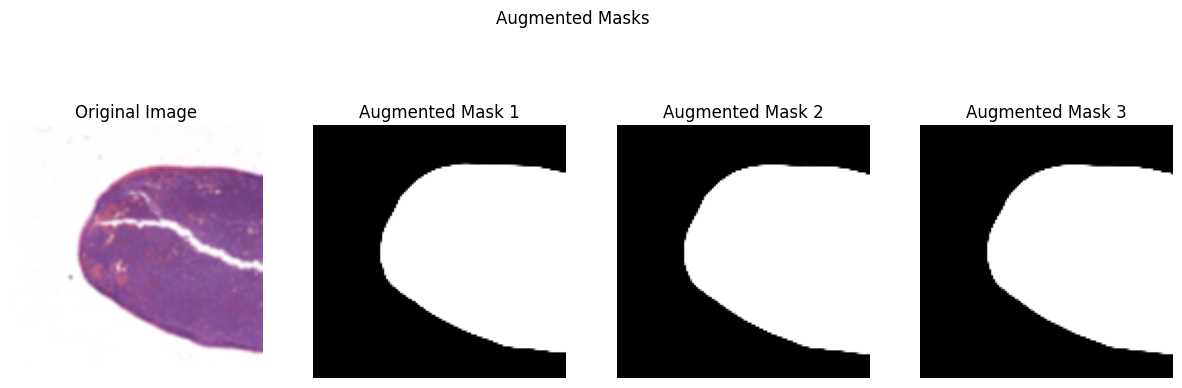

0.9589132761029291
0.9176334101405839
0.9466488826453322
0.8854515042763783
0.0
0.9743156470134647
0.9077416763306292
0.9154484389903405


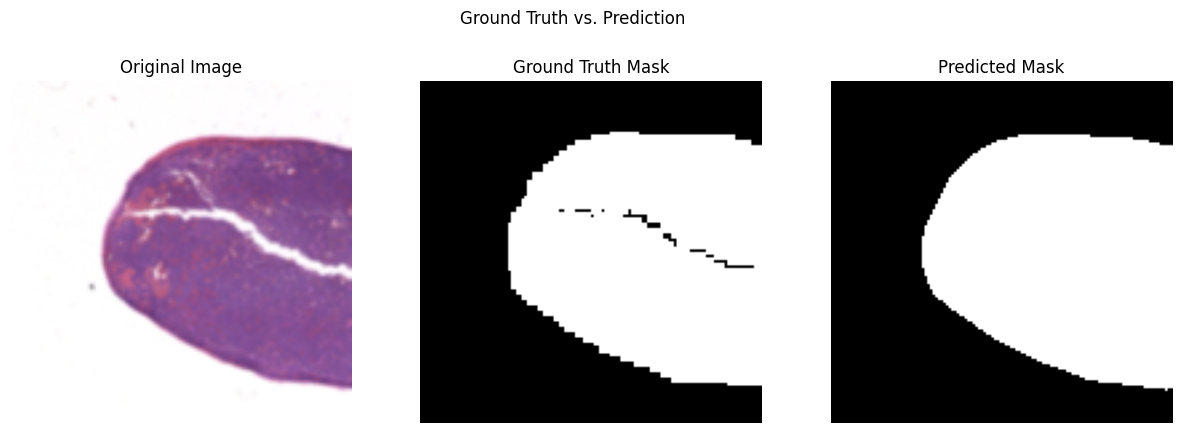

Validation with Augmentation:  20%|██        | 1/5 [00:02<00:09,  2.25s/it]

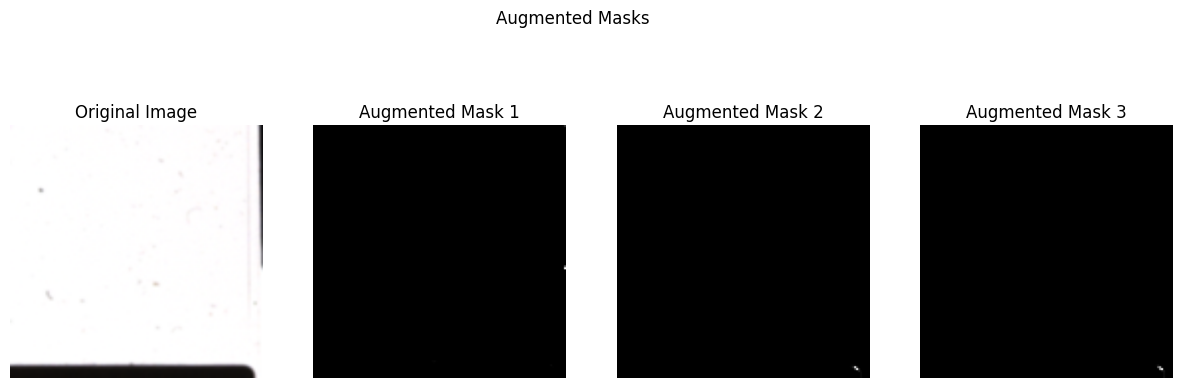

0.0
0.9620985008646469
0.9234731418463074
0.5643910005568693
0.9763469117975776
0.9089790886728425
0.9503916424271759
0.5393890673073195


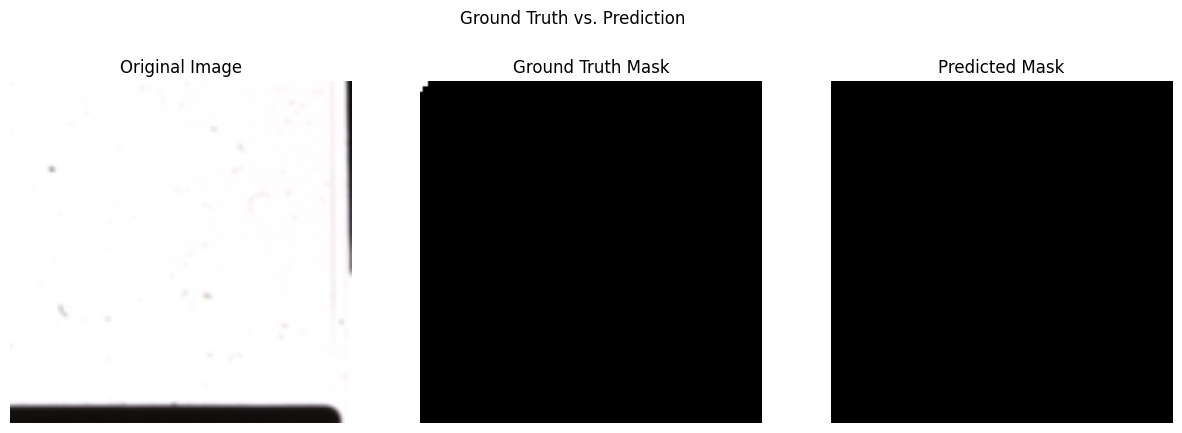

Validation with Augmentation:  40%|████      | 2/5 [00:04<00:06,  2.24s/it]

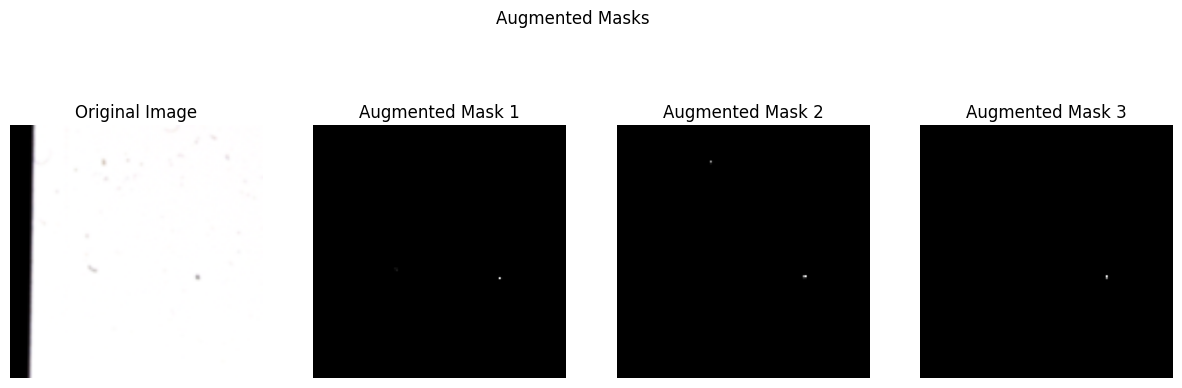

0.0
0.9607935756635501
0.9874763120221244
0.9612354237375929
1.0
0.9271736436800627
0.9594014857215233
0.9210526312423054


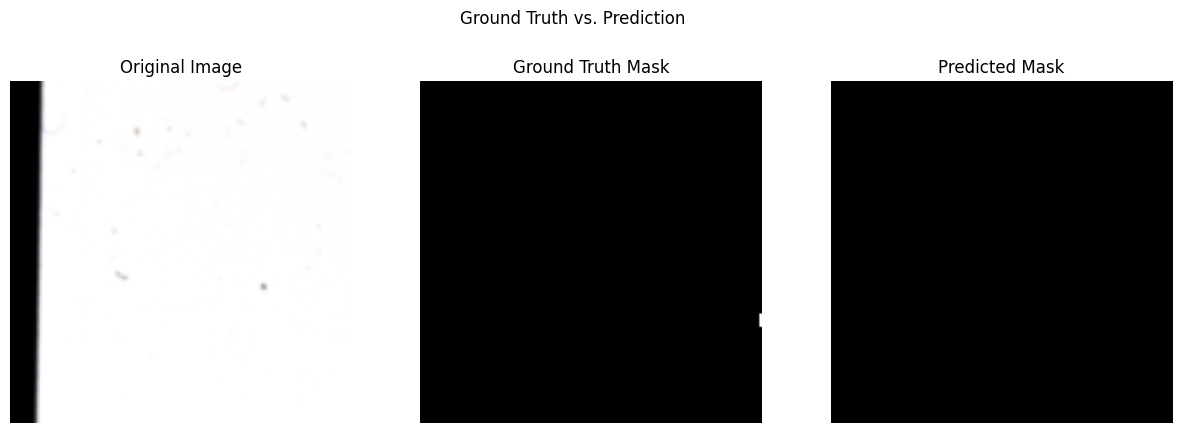

Validation with Augmentation:  60%|██████    | 3/5 [00:06<00:04,  2.23s/it]

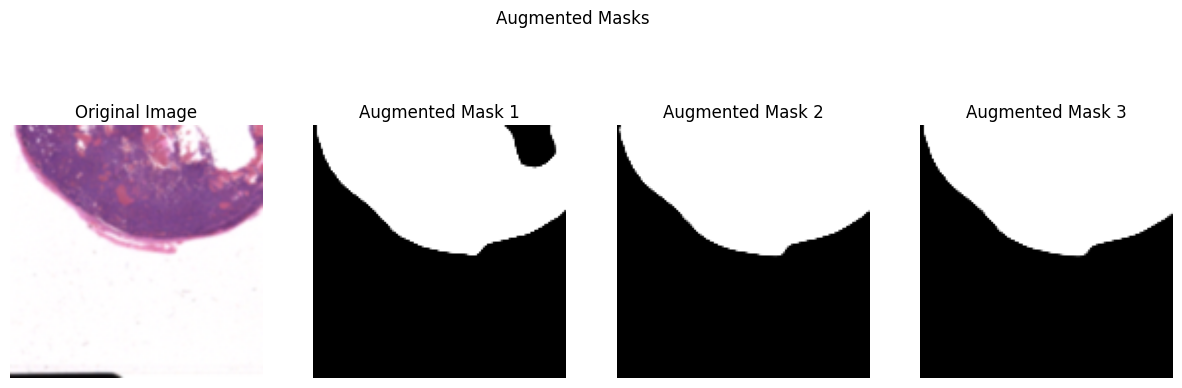

0.9199200736366553
0.6730085347309729
0.9470930230722687
1.0
1.0
0.3862894446286296
0.5195891972158276
0.9254878764485582


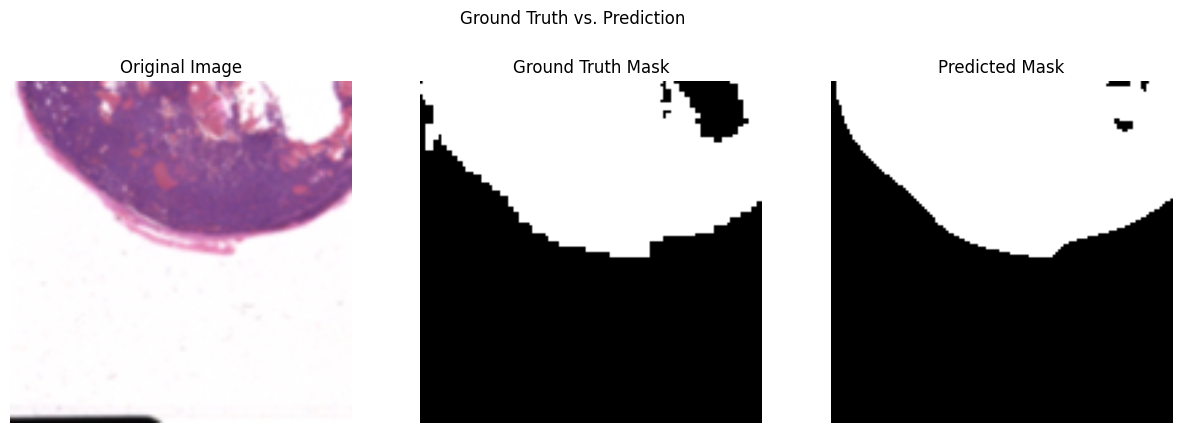

Validation with Augmentation:  80%|████████  | 4/5 [00:08<00:02,  2.25s/it]

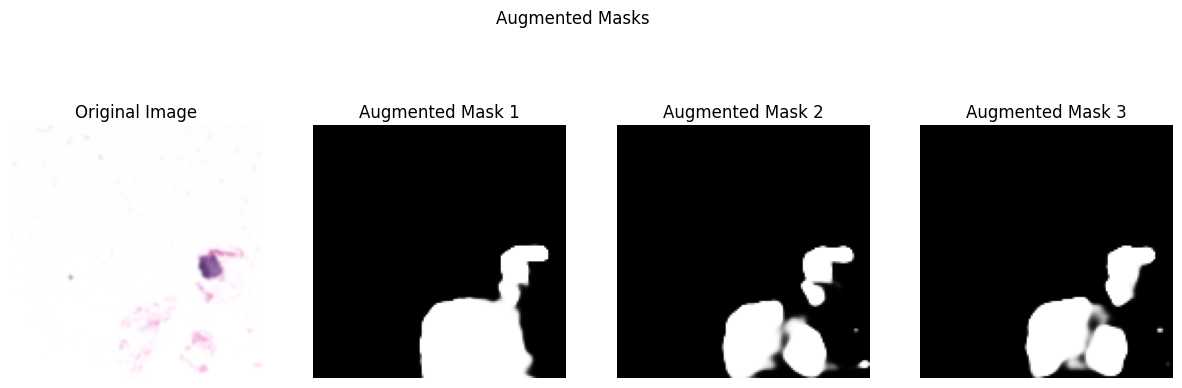

0.5494056461554957
0.8864656829406744
0.7090909047933884


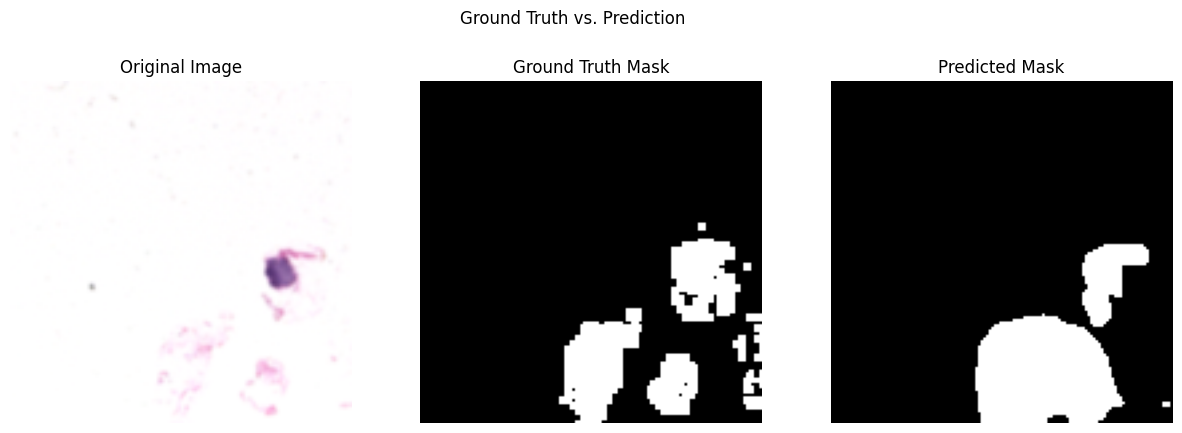

Validation with Augmentation: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it]

Validation Loss: 0.5933
Mean IoU: 0.7876
Mean Dice: 0.8369
Mean Pixel Accuracy: 0.9756


In [136]:
avg_val_loss, avg_iou, avg_dice, avg_pixel_acc = validate_with_augmentation_with_visualization(
    model=model2,
    val_loader=val_loader,
    criterion=loss,
    device=device,
    visualize=True
)

print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Mean IoU: {avg_iou:.4f}")
print(f"Mean Dice: {avg_dice:.4f}")
print(f"Mean Pixel Accuracy: {avg_pixel_acc:.4f}")


In [91]:
from tqdm import tqdm
import torch.nn.functional as F

def validate_without_augmentation(model, val_loader, criterion, device, threshold=0.5):
    """
    Validate the segmentation model without applying any augmentations.

    Args:
        model: The trained segmentation model.
        val_loader: DataLoader providing validation images and ground truth masks.
        criterion: Loss function for evaluation.
        device: Computation device (CPU or CUDA).
        threshold: Threshold to convert logits to binary predictions (default=0.5).

    Returns:
        avg_val_loss: Average validation loss across the validation set.
        avg_iou: Average Intersection over Union (IoU) across the validation set.
        avg_dice: Average Dice coefficient across the validation set.
        avg_pixel_acc: Average pixel accuracy across the validation set.
    """
    model.eval()
    val_loss = 0.0
    total_iou = 0.0
    total_dice = 0.0
    total_pixel_acc = 0.0
    num_samples = 0

    with torch.no_grad():
        for images, ground_truth_masks in tqdm(val_loader, desc="Validation Without Augmentation"):
            # Move inputs and masks to the correct device
            images = images.to(device)
            ground_truth_masks = ground_truth_masks.to(device, dtype=torch.float32)

            # Generate outputs for the original images
            outputs = model(pixel_values=images)
            tissue_logits = outputs.masks_queries_logits[:, 1]  # Binary segmentation logits
            tissue_logits_resized = torch.sigmoid(
                F.interpolate(
                    tissue_logits.unsqueeze(1),  # Add channel dimension
                    size=ground_truth_masks.shape[-2:],  # Match mask size
                    mode="bilinear",
                    align_corners=False,
                )
            )

            # Compute loss
            loss = criterion(tissue_logits_resized, ground_truth_masks)
            val_loss += loss.item()

            # Calculate metrics
            predicted_masks = (tissue_logits_resized > threshold).cpu().numpy().astype(np.uint8)
            ground_truth_masks_np = ground_truth_masks.cpu().numpy().astype(np.uint8)

            for pred, gt in zip(predicted_masks, ground_truth_masks_np):
                total_iou += calculate_iou_infer(pred, gt)
                total_dice += calculate_dice_infer(pred, gt)
                num_samples += 1

            matching_pixels = (predicted_masks == ground_truth_masks_np).sum()  # Count matching pixels per batch
            total_pixels = torch.tensor(predicted_masks).numel()
            total_pixel_acc += float(matching_pixels) / total_pixels

    # Calculate average metrics
    avg_val_loss = val_loss / len(val_loader)
    avg_val_pixel_acc = total_pixel_acc / len(val_loader)
    avg_iou = total_iou / num_samples if num_samples > 0 else 0
    avg_dice = total_dice / num_samples if num_samples > 0 else 0

    return avg_val_loss, avg_iou, avg_dice, avg_val_pixel_acc


In [93]:
avg_val_loss, avg_iou, avg_dice, avg_pixel_acc = validate_without_augmentation(
    model=model2,
    val_loader=val_loader,
    criterion=loss,
    device=device
    )

print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Mean IoU: {avg_iou:.4f}")
print(f"Mean Dice: {avg_dice:.4f}")
print(f"Mean Pixel Accuracy: {avg_pixel_acc:.4f}")


Validation Without Augmentation: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

Validation Loss: 0.5840
Mean IoU: 0.7891
Mean Dice: 0.8374
Mean Pixel Accuracy: 0.9757


In [129]:
def validate_with_augmentation_max_IoU(
    model, val_loader, criterion, device, threshold=0.5, visualize=False
):
    """
    Validate the segmentation model using augmented versions of the input (rotations and flips),
    calculate IoU for each augmented prediction, and take the highest IoU.
    Optionally visualize augmentations and augmented masks.

    Args:
        model: The trained segmentation model.
        val_loader: DataLoader providing validation images and ground truth masks.
        criterion: Loss function for evaluation.
        device: Computation device (CPU or CUDA).
        threshold: Threshold to convert logits to binary predictions (default=0.5).
        visualize (bool): Whether to visualize augmentations and masks (default=False).

    Returns:
        avg_val_loss: Average validation loss across the augmented validation set.
        avg_max_iou: Average maximum IoU across all samples in the validation set.
        avg_dice: Average Dice coefficient across the augmented validation set.
        avg_pixel_acc: Average pixel accuracy across the augmented validation set.
    """
    model.eval()
    val_loss = 0.0
    total_max_iou = 0.0
    total_dice = 0.0
    total_pixel_acc = 0.0
    num_samples = 0

    with torch.no_grad():
        for images, ground_truth_masks in tqdm(val_loader, desc="Validation with Augmentation"):
            images = images.to(device)
            ground_truth_masks = ground_truth_masks.to(device, dtype=torch.float32)

            max_iou = 0.0  # Track the maximum IoU for each sample
            all_predictions = []
            augmented_predictions = []

            # Original prediction
            outputs = model(pixel_values=images)
            tissue_logits = outputs.masks_queries_logits[:, 1]  # Binary segmentation logits
            tissue_logits_resized = torch.sigmoid(
                F.interpolate(
                    tissue_logits.unsqueeze(1),  # Add channel dimension
                    size=ground_truth_masks.shape[-2:],  # Match mask size
                    mode="bilinear",
                    align_corners=False,
                )
            )
            all_predictions.append(tissue_logits_resized)

            # Generate outputs for augmented versions
            augmented_images = [hflip(images), vflip(images), hflip(vflip(images))]
            for idx, aug_image in enumerate(augmented_images):
                aug_outputs = model(pixel_values=aug_image)
                aug_logits = aug_outputs.masks_queries_logits[:, 1]  # Binary segmentation logits
                aug_logits_resized = torch.sigmoid(
                    F.interpolate(
                        aug_logits.unsqueeze(1),  # Add channel dimension
                        size=ground_truth_masks.shape[-2:],  # Match mask size
                        mode="bilinear",
                        align_corners=False,
                    )
                )
                # Flip augmented predictions back to match the original orientation
                if idx == 0:  # hflip
                    aug_logits_resized = hflip(aug_logits_resized)
                elif idx == 1:  # vflip
                    aug_logits_resized = vflip(aug_logits_resized)
                elif idx == 2:  # hflip + vflip
                    aug_logits_resized = hflip(vflip(aug_logits_resized))

                augmented_predictions.append(aug_logits_resized)
                all_predictions.append(aug_logits_resized)

            # Visualize augmented masks if enabled
            if visualize:
                original_image = images[0]  # The first image in the batch
                visualize_augmented_masks(original_image, augmented_predictions)

            # Compute loss for the original image
            loss = criterion(tissue_logits_resized, ground_truth_masks)
            val_loss += loss.item()

            # Compute IoU and find the maximum across augmented versions
            for prediction in all_predictions:
                predicted_masks = (prediction > threshold).cpu().numpy().astype(np.uint8)
                ground_truth_masks_np = ground_truth_masks.cpu().numpy().astype(np.uint8)

                # Compute IoU for each prediction
                for pred, gt in zip(predicted_masks, ground_truth_masks_np):
                    iou = calculate_iou_infer(pred, gt)
                    max_iou = max(max_iou, iou)  # Update maximum IoU
                    min_iou = min(max_iou, iou)  # Update minimum IoU
                print(min_iou)

                print(max_iou)

            total_max_iou += max_iou  # Add maximum IoU for this batch
            print(total_max_iou)

    #         # Compute Dice coefficient and pixel accuracy
    #         for pred, gt in zip(predicted_masks, ground_truth_masks_np):
    #             total_dice += calculate_dice_infer(pred, gt)
    #             matching_pixels = (pred == gt).sum()
    #             total_pixels = pred.size
    #             total_pixel_acc += float(matching_pixels) / total_pixels

    #         num_samples += len(images)
    #         print(num_samples)

    #         # Visualize predictions if enabled
            if visualize:
                original_image = images[0]  # The first image in the batch
                ground_truth_mask = ground_truth_masks[0]  # Corresponding ground truth mask
                predicted_mask = (tissue_logits_resized[0] > threshold).cpu()  # Threshold the first prediction
                visualize_predictions(original_image, ground_truth_mask, predicted_mask)

    # # Average metrics
    # avg_val_loss = val_loss / len(val_loader)
    # avg_max_iou = total_max_iou / num_samples
    # avg_dice = total_dice / num_samples if num_samples > 0 else 0
    # avg_pixel_acc = total_pixel_acc / num_samples if num_samples > 0 else 0

    # return avg_val_loss, avg_max_iou, avg_dice, avg_pixel_acc

            predicted_masks = (tissue_logits_resized > threshold).cpu().numpy().astype(np.uint8)
            ground_truth_masks_np = ground_truth_masks.cpu().numpy().astype(np.uint8)

            for pred, gt in zip(predicted_masks, ground_truth_masks_np):
                total_max_iou += calculate_iou_infer(pred, gt)
                total_dice += calculate_dice_infer(pred, gt)
                num_samples += 1

            matching_pixels = (predicted_masks == ground_truth_masks_np).sum()  # Count matching pixels per batch
            total_pixels = torch.tensor(predicted_masks).numel()
            total_pixel_acc += float(matching_pixels) / total_pixels

    # Calculate average metrics
    avg_val_loss = val_loss / len(val_loader)
    avg_val_pixel_acc = total_pixel_acc / len(val_loader)
    avg_iou = total_max_iou / num_samples if num_samples > 0 else 0
    avg_dice = total_dice / num_samples if num_samples > 0 else 0

    return avg_val_loss, avg_iou, avg_dice, avg_val_pixel_acc


Validation with Augmentation:   0%|          | 0/5 [00:00<?, ?it/s]

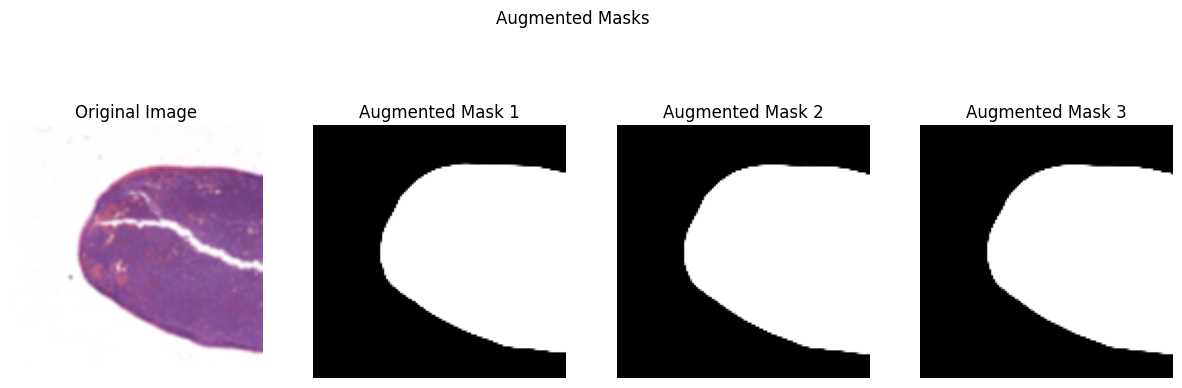

0.909341741856783
0.9771882391049023
0.9144684248942972
0.9771882391049023
0.9163393554924041
0.9771882391049023
0.927165353965683
0.9771882391049023
0.9771882391049023


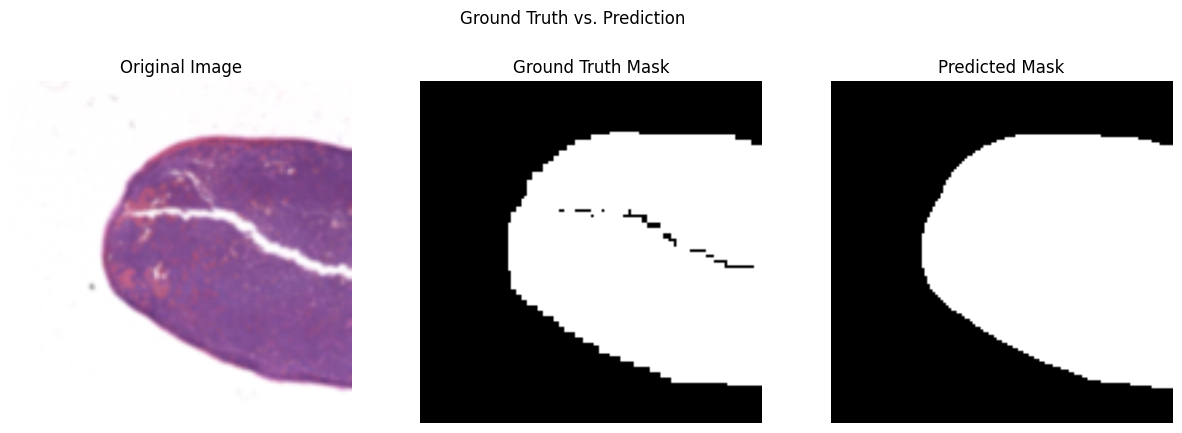

Validation with Augmentation:  20%|██        | 1/5 [00:02<00:09,  2.27s/it]

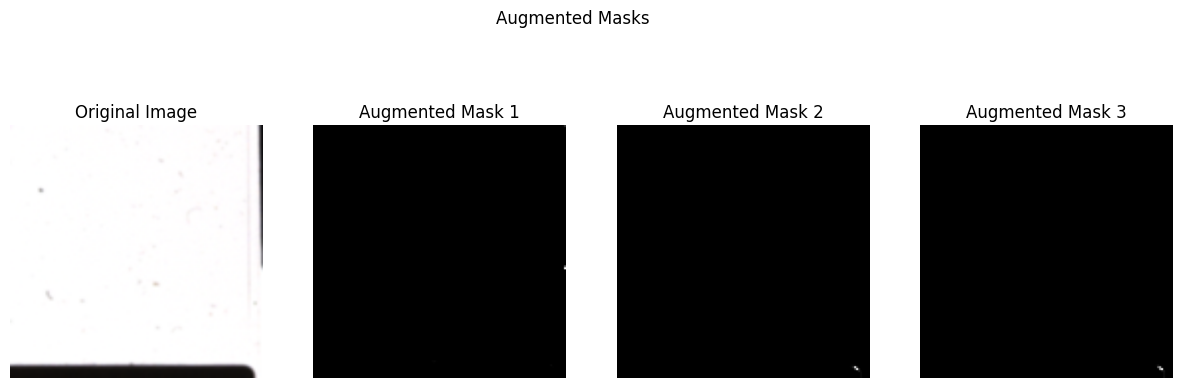

0.5021910602532029
0.9790163932821284
0.5127334463018959
0.9790163932821284
0.5034482756884662
0.9790163932821284
0.5395683451194365
0.9790163932821284
8.49246269100972


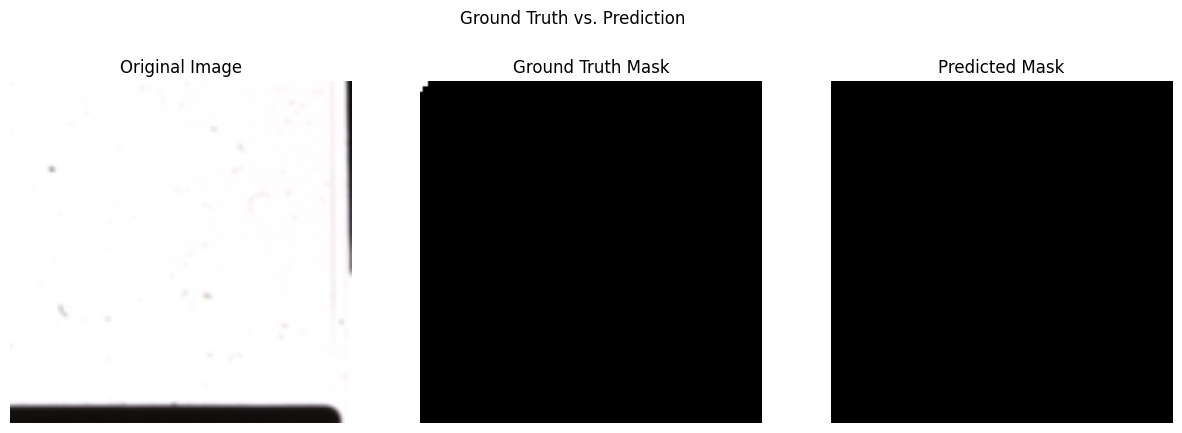

Validation with Augmentation:  40%|████      | 2/5 [00:04<00:06,  2.25s/it]

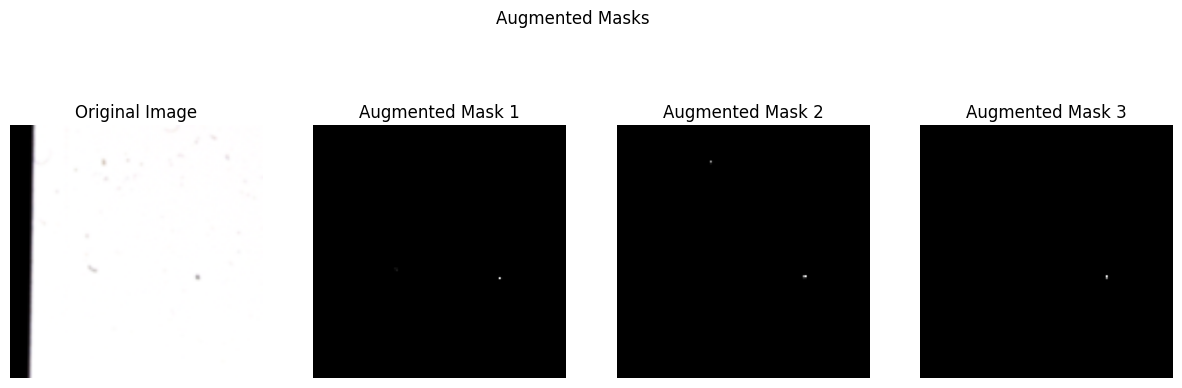

0.9225479547873515
1.0
0.9114244392944959
1.0
0.9176427522263387
1.0
0.8950073418153425
1.0
15.247134187936453


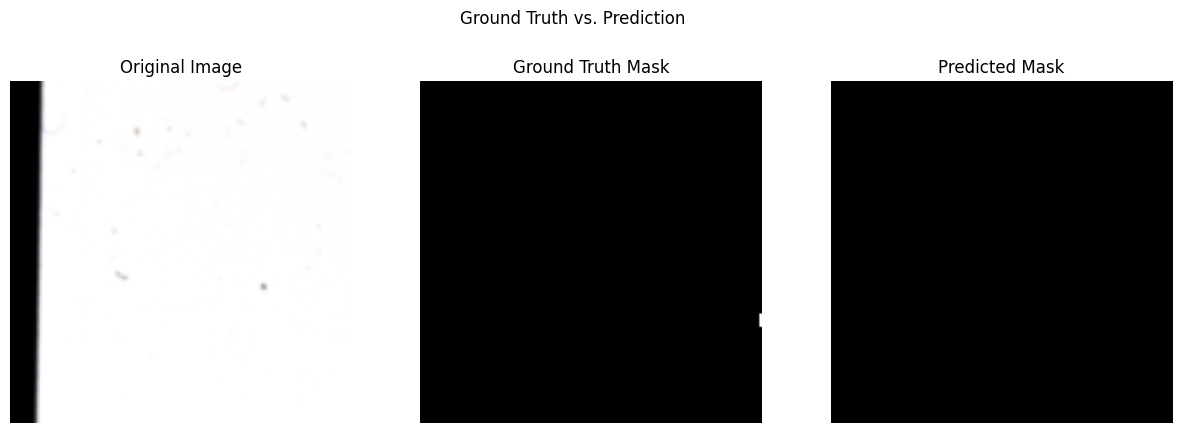

Validation with Augmentation:  60%|██████    | 3/5 [00:06<00:04,  2.24s/it]

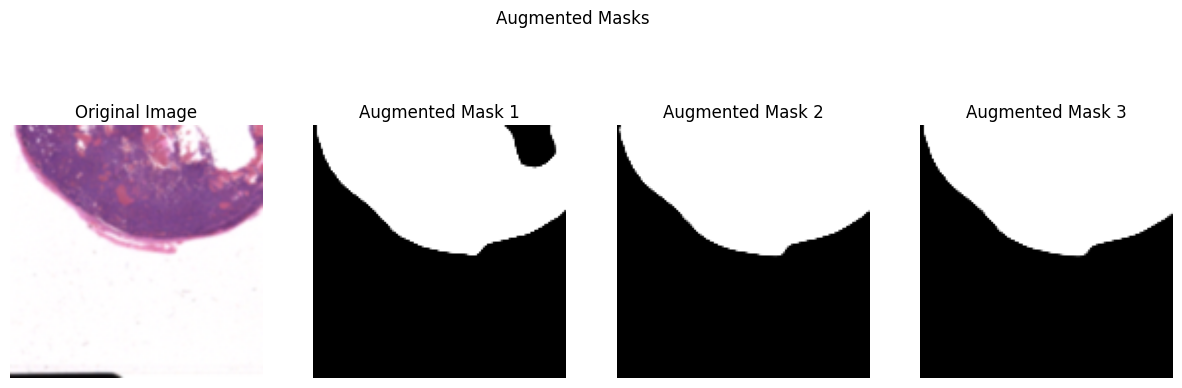

0.9325443781464234
1.0
0.9284869970871825
1.0
0.9165680467949301
1.0
0.9273479025827832
1.0
22.973000009693298


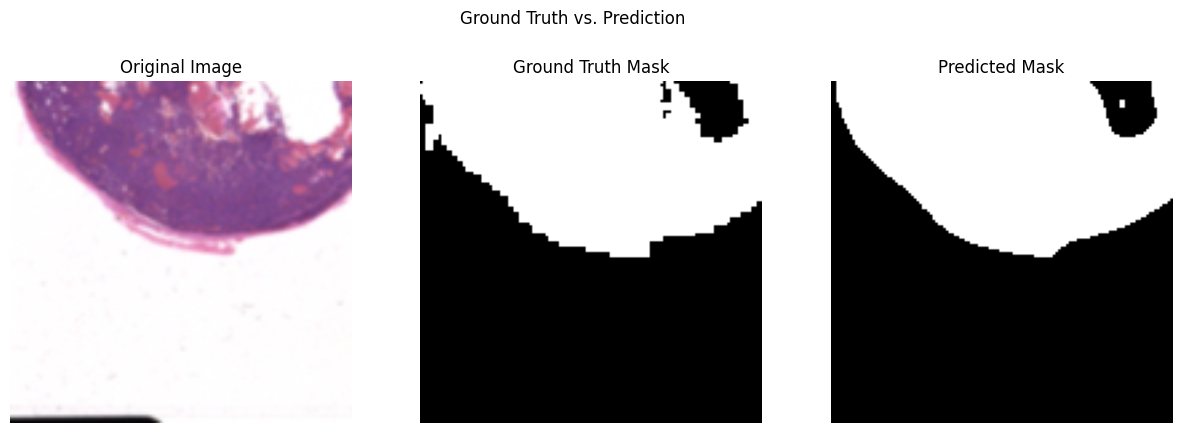

Validation with Augmentation:  80%|████████  | 4/5 [00:09<00:02,  2.26s/it]

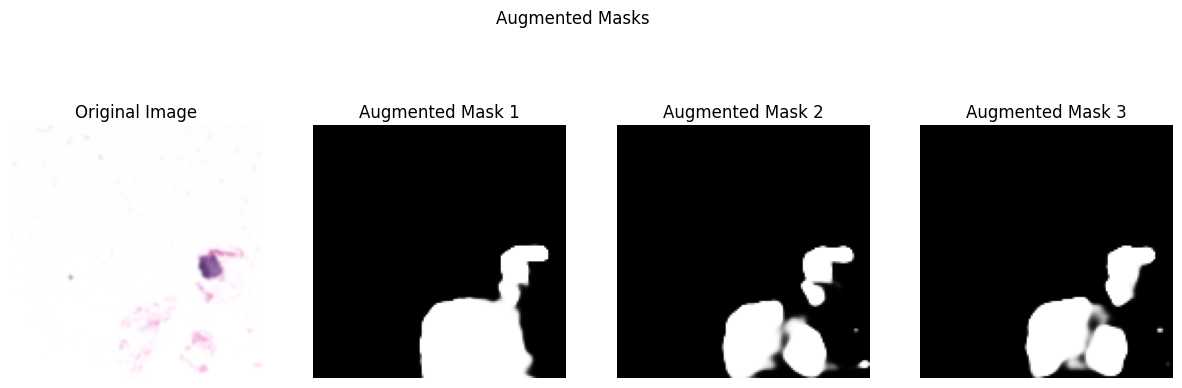

0.720496889934802
0.8895063045758695
0.6802325541846944
0.9182403908202087
0.7073170688578228
0.9182403908202087
0.6763005741254302
0.9182403908202087
30.361965613318798


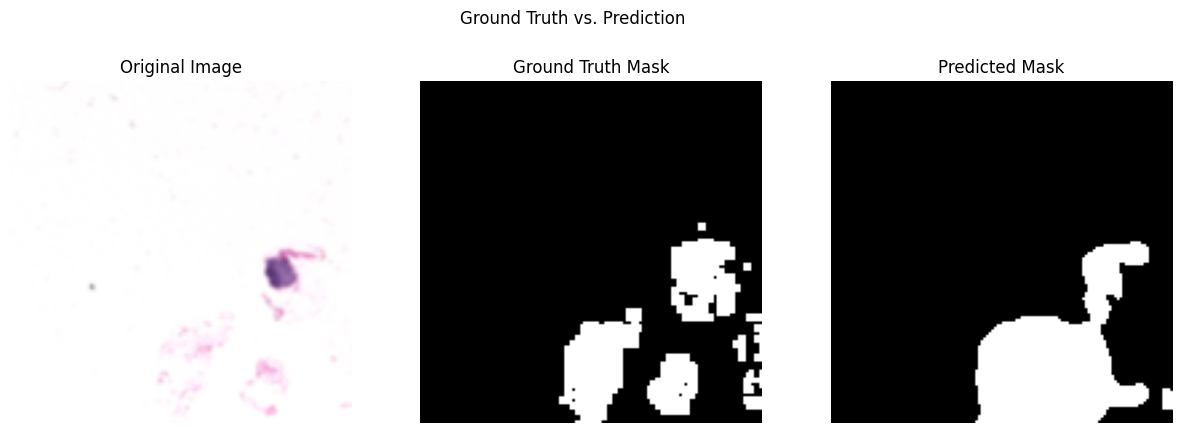

Validation with Augmentation: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it]

Validation Loss: 0.5840
Mean IoU: 0.9283
Mean Dice: 0.8374
Mean Pixel Accuracy: 0.9757


In [130]:
avg_val_loss, avg_iou, avg_dice, avg_pixel_acc = validate_with_augmentation_max_IoU(
    model=model2,
    val_loader=val_loader,
    criterion=loss,
    device=device,
    visualize=True
)

print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Mean IoU: {avg_iou:.4f}")
print(f"Mean Dice: {avg_dice:.4f}")
print(f"Mean Pixel Accuracy: {avg_pixel_acc:.4f}")


In [133]:
def validate_with_augmentation_max_IoU(
    model, val_loader, criterion, device, threshold=0.5, visualize=False
):
    """
    Validate the segmentation model using augmented versions of the input (rotations and flips),
    calculate IoU for each augmented prediction, and take the highest IoU.
    Optionally visualize augmentations and augmented masks.

    Args:
        model: The trained segmentation model.
        val_loader: DataLoader providing validation images and ground truth masks.
        criterion: Loss function for evaluation.
        device: Computation device (CPU or CUDA).
        threshold: Threshold to convert logits to binary predictions (default=0.5).
        visualize (bool): Whether to visualize augmentations and masks (default=False).

    Returns:
        avg_val_loss: Average validation loss across the augmented validation set.
        avg_mean_iou: Average mean IoU across all samples in the validation set.
        avg_dice: Average Dice coefficient across the augmented validation set.
        avg_pixel_acc: Average pixel accuracy across the augmented validation set.
    """
    model.eval()
    val_loss = 0.0
    total_mean_iou = 0.0
    total_dice = 0.0
    total_pixel_acc = 0.0
    num_samples = 0

    with torch.no_grad():
        for images, ground_truth_masks in tqdm(val_loader, desc="Validation with Augmentation"):
            images = images.to(device)
            ground_truth_masks = ground_truth_masks.to(device, dtype=torch.float32)

            max_iou = 0.0  # Track the maximum IoU for each sample
            best_mask = None  # Store the mask with the highest IoU

            # Original prediction
            outputs = model(pixel_values=images)
            tissue_logits = outputs.masks_queries_logits[:, 1]  # Binary segmentation logits
            tissue_logits_resized = torch.sigmoid(
                F.interpolate(
                    tissue_logits.unsqueeze(1),  # Add channel dimension
                    size=ground_truth_masks.shape[-2:],  # Match mask size
                    mode="bilinear",
                    align_corners=False,
                )
            )

            # Add the original prediction to all_predictions
            predictions = [tissue_logits_resized]

            # Generate outputs for augmented versions
            augmented_images = [hflip(images), vflip(images), hflip(vflip(images))]
            for idx, aug_image in enumerate(augmented_images):
                aug_outputs = model(pixel_values=aug_image)
                aug_logits = aug_outputs.masks_queries_logits[:, 1]  # Binary segmentation logits
                aug_logits_resized = torch.sigmoid(
                    F.interpolate(
                        aug_logits.unsqueeze(1),  # Add channel dimension
                        size=ground_truth_masks.shape[-2:],  # Match mask size
                        mode="bilinear",
                        align_corners=False,
                    )
                )
                # Flip augmented predictions back to match the original orientation
                if idx == 0:  # hflip
                    aug_logits_resized = hflip(aug_logits_resized)
                elif idx == 1:  # vflip
                    aug_logits_resized = vflip(aug_logits_resized)
                elif idx == 2:  # hflip + vflip
                    aug_logits_resized = hflip(vflip(aug_logits_resized))

                predictions.append(aug_logits_resized)

            # Compute IoU and find the maximum across augmented versions
            for prediction in predictions:
                predicted_masks = (prediction > threshold).cpu().numpy().astype(np.uint8)
                ground_truth_masks_np = ground_truth_masks.cpu().numpy().astype(np.uint8)

                for pred, gt in zip(predicted_masks, ground_truth_masks_np):
                    iou = calculate_iou_infer(pred, gt)
                    if iou > max_iou:
                        max_iou = iou
                        best_mask = pred  # Save the mask with the highest IoU

            print(max_iou)

            # Add the maximum IoU for this sample to the total mean IoU
            total_mean_iou += max_iou

            # Compute Dice coefficient and pixel accuracy using the best mask
            for pred, gt in zip([best_mask], ground_truth_masks_np):
                total_dice += calculate_dice_infer(pred, gt)
                matching_pixels = (pred == gt).sum()
                total_pixels = pred.size
                total_pixel_acc += float(matching_pixels) / total_pixels

            # Compute loss for the original image
            loss = criterion(tissue_logits_resized, ground_truth_masks)
            val_loss += loss.item()
            num_samples += len(images)

            # Visualize predictions if enabled
            if visualize:
                original_image = images[0]  # The first image in the batch
                ground_truth_mask = ground_truth_masks[0]  # Corresponding ground truth mask
                predicted_mask = (tissue_logits_resized[0] > threshold).cpu()  # Threshold the first prediction
                visualize_predictions(original_image, ground_truth_mask, predicted_mask)

    # Calculate average metrics
    avg_val_loss = val_loss / len(val_loader)
    avg_mean_iou = total_mean_iou / num_samples if num_samples > 0 else 0
    avg_dice = total_dice / num_samples if num_samples > 0 else 0
    avg_pixel_acc = total_pixel_acc / num_samples if num_samples > 0 else 0

    return avg_val_loss, avg_mean_iou, avg_dice, avg_pixel_acc


Validation with Augmentation:   0%|          | 0/5 [00:00<?, ?it/s]

0.9771882391049023


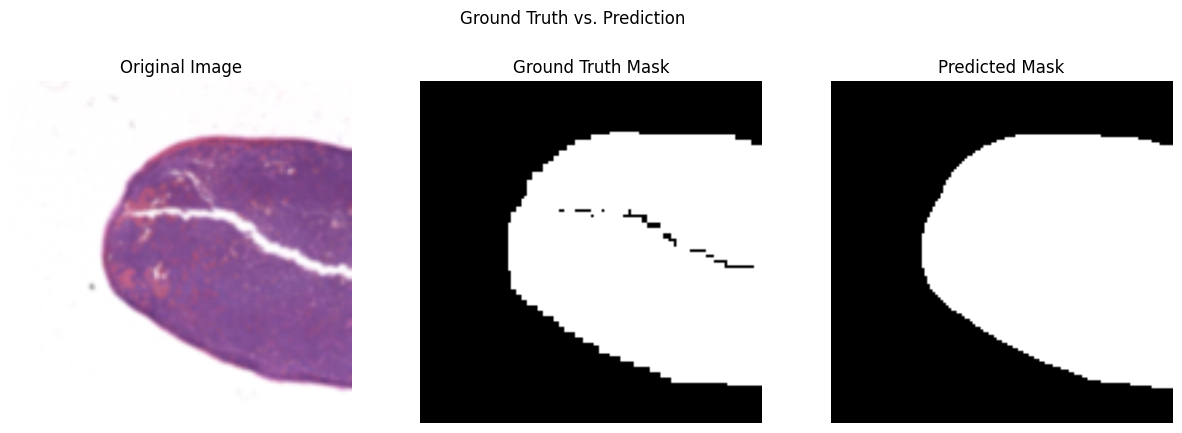

Validation with Augmentation:  20%|██        | 1/5 [00:01<00:07,  1.97s/it]

0.9790163932821284


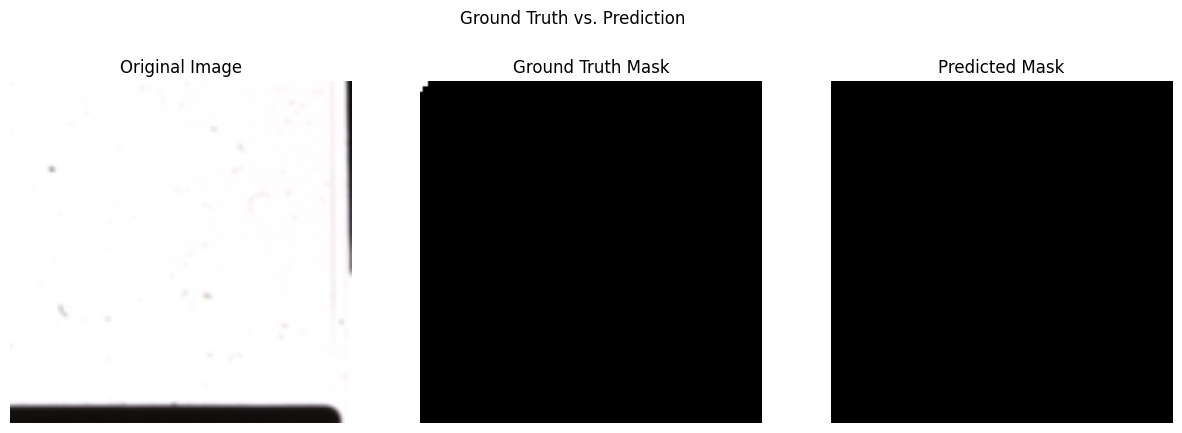

Validation with Augmentation:  40%|████      | 2/5 [00:03<00:05,  1.96s/it]

1.0


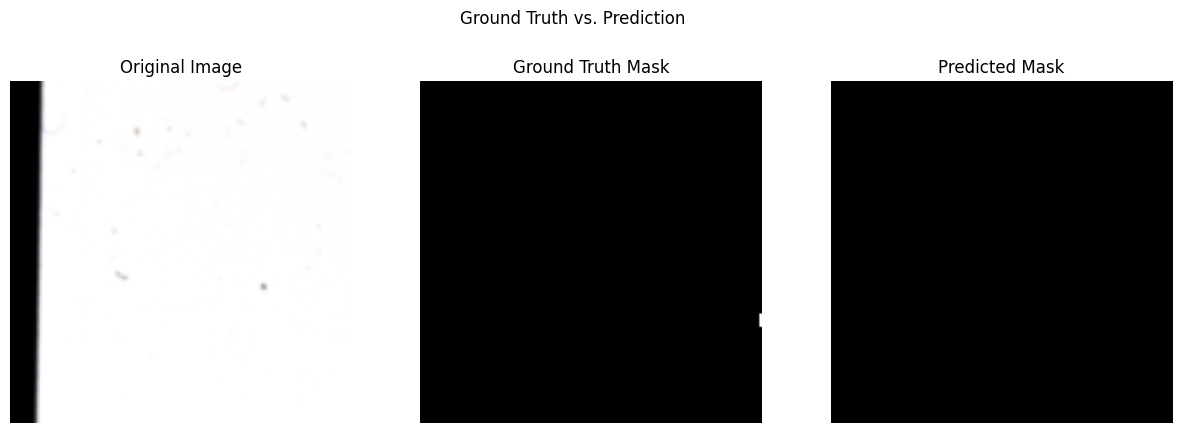

Validation with Augmentation:  60%|██████    | 3/5 [00:05<00:03,  1.95s/it]

1.0


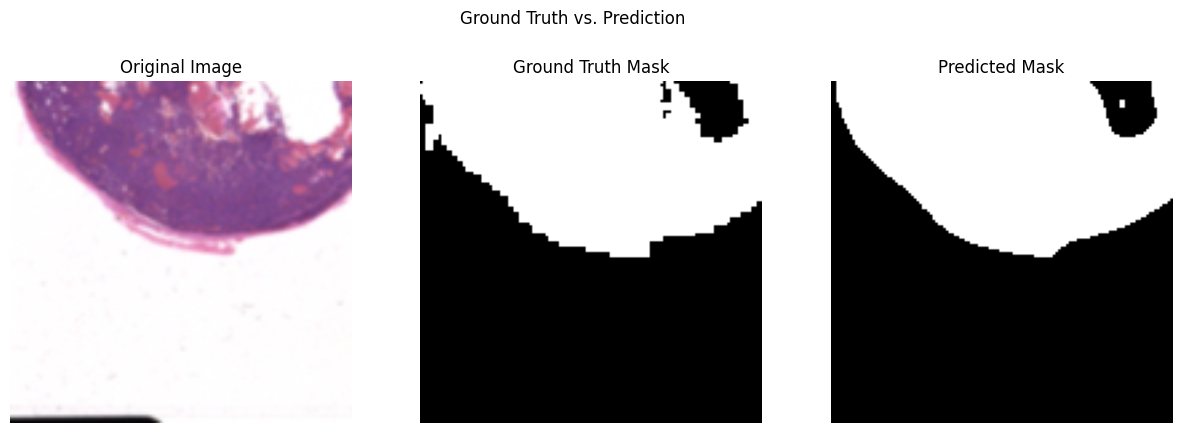

Validation with Augmentation:  80%|████████  | 4/5 [00:08<00:02,  2.12s/it]

0.9182403908202087


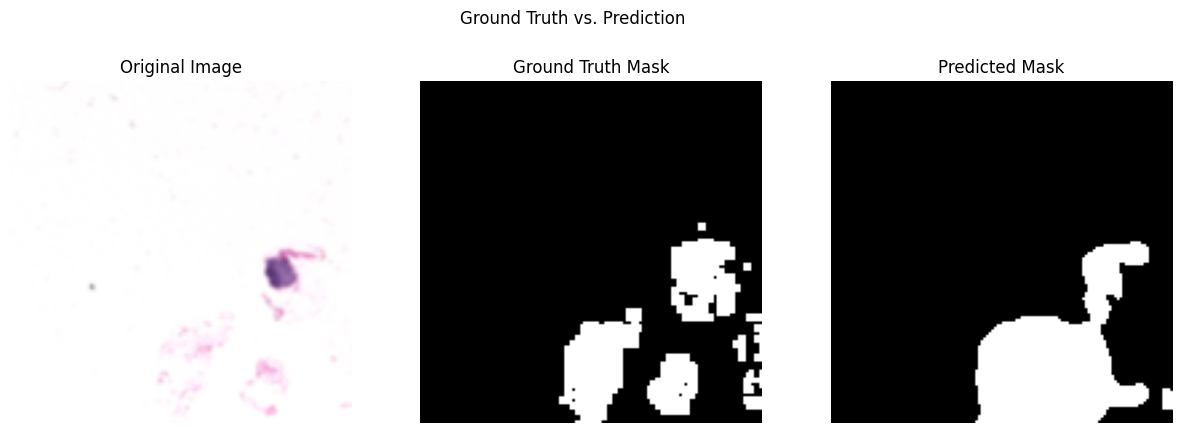

Validation with Augmentation: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]

Validation Loss: 0.5840
Mean IoU: 0.1393
Mean Dice: 0.0385
Mean Pixel Accuracy: 0.1120


In [134]:
avg_val_loss, avg_iou, avg_dice, avg_pixel_acc = validate_with_augmentation_max_IoU(
    model=model2,
    val_loader=val_loader,
    criterion=loss,
    device=device,
    visualize=True
)

print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Mean IoU: {avg_iou:.4f}")
print(f"Mean Dice: {avg_dice:.4f}")
print(f"Mean Pixel Accuracy: {avg_pixel_acc:.4f}")